# Analysis Notebook


In this notebook, we include all the experiments run during the exploratory analysis of BARTScore. As part of any analysis, we should be familiar with the details of the datasets. We collected the details and summarize them in the next section. 


## Evaluation Aspects

We now copy the definition of the different evaluation aspects defined in the Section 2.2. of BARTScore paper.

- **Informativeness** (INFO): How well does the generated hypothesis capture the key ideas of the source text.

- **Relevance** (REL): How consistent the generated hypothesis is wrt the source text.

- **Fluency** (FLU): Whether the text has no formatting problems, capitalization errors or obviously ungrammatical sentences (e.g., fragments, missing components) that make the text difficult to read.

- **Coherence** (COH): Whether the text builds from sentence to sentence to a coherent body of information about a topic.

- **Factuality** (FAC): Whether the generated hypothesis contains only statements entailed by the source text.

- **Semantic Coverage** (COV): How many semantic content units from reference texts are covered by the generated hypothesis.

- **Adequacy** (ADE): Whether the output conveys the same meaning as the input sentence, and none of the message is lost, added, or distorted.


**Observations** about the evaluation aspects:
- Some aspects are distinct but others are deeply correlated.
- Fluency and coeherence are related but the former focuses on phrases whereas the latter focuses on a sentence-to-sentence level.
- Relevance and Factuality alude to the same property (consistency between source text and generated hypothesis).
- Semantic coverage and Adequacy are related, if we have low semantic coverage we may expect lower adequacy but not necessarily lower factuality (since factuality is related to addition of new information).
- Informativeness is also related to the semantic coverage.


- Given the interplay between the different evaluation aspects, it is important to measure the extent to which they are correlated. 
    - [ ] Does it differ across domains?
    - [ ] Does their correlation change with models? (if so, this may suggest different models are better modelers of specific aspects?
    


## Datasets


BARTScore paper uses a total of 6 summarization, 3 data-to-text datasets, and 1 machine translation dataset (but explore 7 language pairs). Depending on the datasets and on their annotations, the authors evaluate different aspects of quality.



|  Dataset | Orig Dataset | N | Eval Aspect | # Annots | Annot Protocol |
| ---------- | ----------- | --- | --- | --- | --- | 
| RealSumm (2020) | CNN/DM | 100 | COV | 4 binary (pres/not pres) | Humans annotate w/ semantic concepts existing in each summary. Filter out noise from 4-way annotations "present/not present". Take the majority vote to assign the final annotation, to concept. Compute Recall. |
| SummEval (2020) | CNN/DM | 100 | COH, FAC, FLU, INFO | 3 exp, avg (1-5 scale) | Collect both crowdsourced and expert annotations of 4 different evaluation dimensions. Coherence and relevance are subjective and have higher disagreement. Correlations are compared for each expert individually and averaged in the end over expert annotations. |
| NeR18 (2018) | News Articles | 60 | COH, FLU, REL, INFO | 3 avg (1-5 scale) | 3-way annotations per summary, using 1-5 Likert scales (1 for each eval dimension). Lack details in the paper, but I assume they are reporting the final results by avg over the 3 annotators. |
| WMT19-DARR | news-related | 9.7k | ADE | Relative Ranking | Use direct assessment (human score 0-100 scale, standardized per annotator). DA scores for the same input language are transformed into relative rankings. MInimum point difference is 25. This can be used to compute the kendall-tau. |

In [24]:
import pandas as pd
import pickle


def read_pickle(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
    return data

In [25]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Math processing
import numpy as np

This is the demo to showcase some analysis process. For the analysis for each task, we have provided a corresponding class. 

In [26]:
# import analysis tools
from analysis import SUMStat, D2TStat, WMTStat

def truncate_print(l, n=10):
    """ Print the first n items of a list"""
    for i, x in enumerate(l):
        if i == n:
            print('...')
            break
        print(x)
        
        
def get_dataframe(data, metrics=None):
    print("Evaluation dataset:", len(data), "examples")

    from collections import defaultdict
    model_data = defaultdict(list)

    for doc_id, doc_metadata in data.items():
        doc_models_metadata = doc_metadata["sys_summs"]

        for model_name, model_metadata in doc_models_metadata.items():
            model_data["id"].append(doc_id)
            model_data["model"].append(model_name)
            model_data["src"].append(doc_metadata["src"])
            model_data["reference"].append(doc_metadata["ref_summ"])
            model_data["candidate"].append(model_metadata["sys_summ"])
            
            for metric, score in model_metadata["scores"].items():
                if metrics is None or metric in metrics:
                    model_data[metric].append(float(score))

    return pd.DataFrame(model_data).sort_values(by="id").reset_index(drop=True)

## Summarization

For all summarization datasets, including **REALSumm**, **SummEval** and **Newsroom**, the analysis tools are the same.

In [30]:
# The path to the scored file, _p means we have prompted metrics
realsumm_stat = SUMStat('SUM/REALSumm/final_p.pkl')
print("Human metrics for REALSumm:", realsumm_stat.human_metrics)
realsumm = get_dataframe(realsumm_stat.data)
realsumm_bs_col = "bart_score_cnn_hypo_ref"
realsumm_human_cols = ['litepyramid_recall']

summeval_stat = SUMStat('SUM/SummEval/final_p.pkl')
print()
print("Human metrics for SummEval:", summeval_stat.human_metrics)
summeval = get_dataframe(summeval_stat.data)
summeval_bs_col = "bart_score_cnn_src_hypo"
summeval_human_cols = ['coherence', 'consistency', 'fluency', 'relevance']

newsroom_stat = SUMStat('SUM/Newsroom/final_p.pkl')
print()
print("Human metrics for Newsroom:", newsroom_stat.human_metrics)
newsroom = get_dataframe(newsroom_stat.data)
newsroom_bs_col = "bart_score_cnn_src_hypo"
newsroom_human_cols = ['coherence', 'fluency', 'informativeness', 'relevance']

Human metrics for REALSumm: ['litepyramid_recall']
Evaluation dataset: 100 examples

Human metrics for SummEval: ['coherence', 'consistency', 'fluency', 'relevance']
Evaluation dataset: 100 examples

Human metrics for Newsroom: ['coherence', 'fluency', 'informativeness', 'relevance']
Evaluation dataset: 60 examples


### Correlation between different evaluation aspects


Text(0.5, 1.0, 'NeR18')

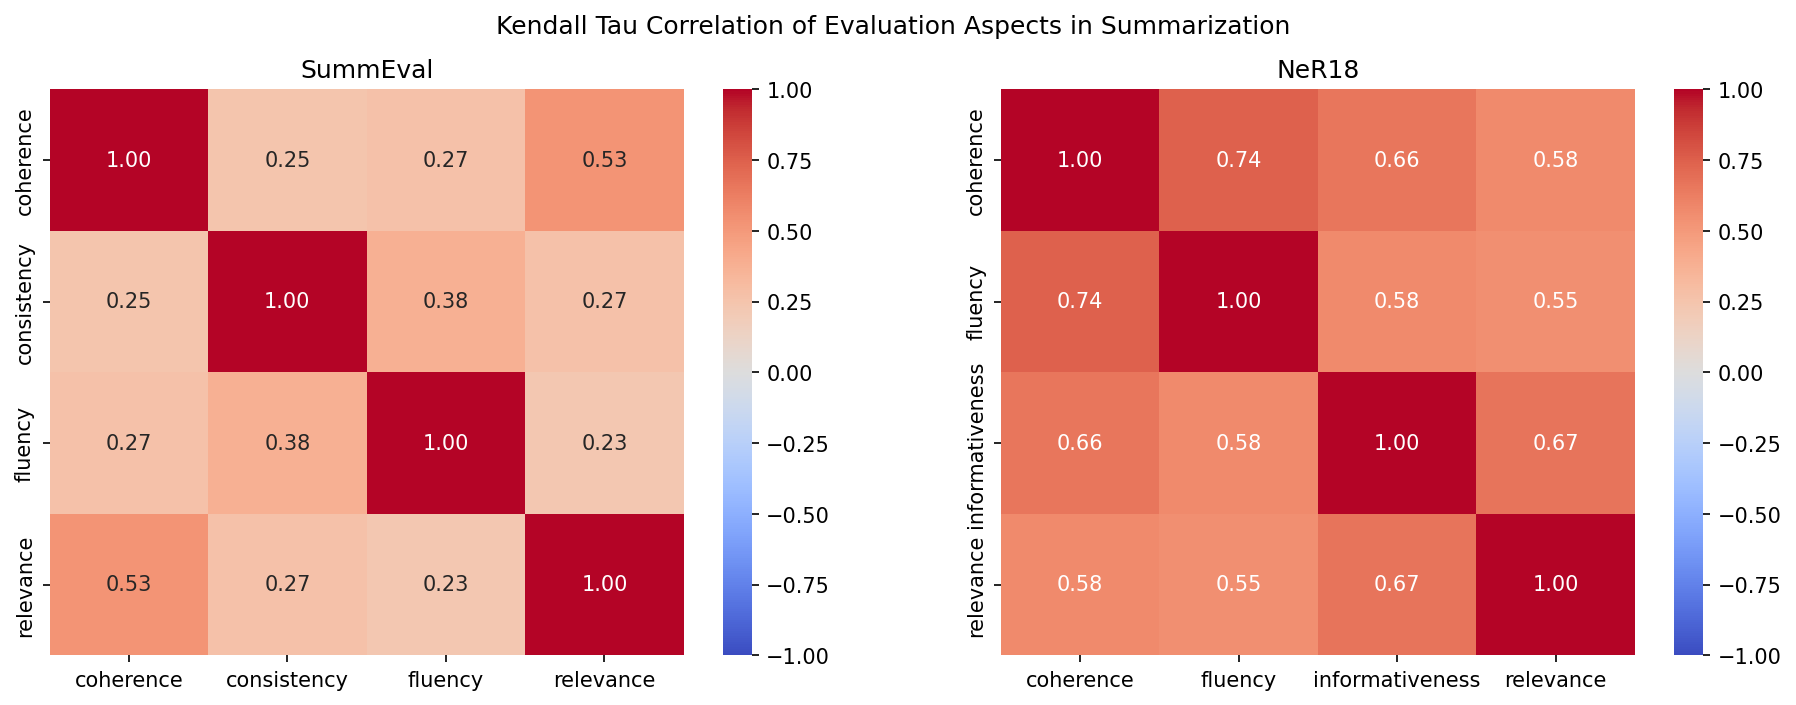

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
fig.suptitle("Kendall Tau Correlation of Evaluation Aspects in Summarization")

corrs = summeval[summeval_human_cols].corr(method="kendall")
sns.heatmap(corrs, vmin=-1, vmax=1, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
axes[0].set_title("SummEval")

corrs = newsroom[newsroom_human_cols].corr(method="kendall")
sns.heatmap(corrs, vmin=-1, vmax=1, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
axes[1].set_title("NeR18")

### SummEval Annotation Uncertainty

What annotations did they use?

The original summeval file is organized as follows:
```json
{"id": "dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2", 
"decoded": "paul merson was brought on with only seven minutes remaining in his team 's 0-0 draw with burnley . andros townsend scored the tottenham midfielder in the 89th minute . paul merson had another dig at andros townsend after his appearance . the midfielder had been brought on to the england squad last week . click here for all the latest arsenal news news .", 
"expert_annotations": [
    {"coherence": 2, "consistency": 1, "fluency": 4, "relevance": 2},
    {"coherence": 1, "consistency": 1, "fluency": 2, "relevance": 1},
    {"coherence": 1, "consistency": 1, "fluency": 3, "relevance": 2}], 
"turker_annotations": [
    {"coherence": 3, "consistency": 3, "fluency": 4, "relevance": 3}, 
    {"coherence": 3, "consistency": 3, "fluency": 4, "relevance": 3},
    {"coherence": 3, "consistency": 3, "fluency": 4, "relevance": 3}, 
    {"coherence": 3, "consistency": 3, "fluency": 4, "relevance": 3}, 
    {"coherence": 3, "consistency": 3, "fluency": 4, "relevance": 3}
], 
"references": [
    <ref1>, 
    ..., 
    <ref10>
], 
    "model_id": "M11", 
    "filepath": "cnndm/dailymail/stories/8764fb95bfad8ee849274873a92fb8d6b400eee2.story"
}

```

It appears that they restrict themselves to using the **average of the expert annotations**.

In [6]:
from collections import defaultdict

ORIGINAL_SUMM_EVAL_CSV = "https://storage.googleapis.com/sfr-summarization-repo-research/model_annotations.aligned.jsonl" 
summeval_orig = pd.read_json(ORIGINAL_SUMM_EVAL_CSV, lines=True)
summeval_orig.head()

,id,decoded,expert_annotations,turker_annotations,references,model_id,filepath
0,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson was brought on with only seven min...,"[{'coherence': 2, 'consistency': 1, 'fluency':...","[{'coherence': 3, 'consistency': 3, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M11,cnndm/dailymail/stories/8764fb95bfad8ee8492748...
1,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson has restarted his row with andros ...,"[{'coherence': 3, 'consistency': 5, 'fluency':...","[{'coherence': 2, 'consistency': 3, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M13,cnndm/dailymail/stories/8764fb95bfad8ee8492748...
2,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson has restarted his row with andros ...,"[{'coherence': 2, 'consistency': 5, 'fluency':...","[{'coherence': 4, 'consistency': 5, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M1,cnndm/dailymail/stories/8764fb95bfad8ee8492748...
3,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson has restarted his row with andros ...,"[{'coherence': 2, 'consistency': 5, 'fluency':...","[{'coherence': 5, 'consistency': 5, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M14,cnndm/dailymail/stories/8764fb95bfad8ee8492748...
4,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson has restarted his row with andros ...,"[{'coherence': 4, 'consistency': 5, 'fluency':...","[{'coherence': 2, 'consistency': 4, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M15,cnndm/dailymail/stories/8764fb95bfad8ee8492748...


In [7]:
summeval_orig_ddict = defaultdict(list)

for idx, row in summeval_orig.iterrows():    
    for exp_annot in row["expert_annotations"]:
        summeval_orig_ddict["id"].append(row["id"])
        summeval_orig_ddict["decoded"].append(row["decoded"])
        summeval_orig_ddict["model_id"].append(row["model_id"])
        summeval_orig_ddict["filepath"].append(row["filepath"])
        
        # Add evaluation aspets
        for col, val in exp_annot.items():
            summeval_orig_ddict[col].append(val)

summeval_orig = pd.DataFrame(summeval_orig_ddict)
summeval_orig

,id,decoded,model_id,filepath,coherence,consistency,fluency,relevance
0,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson was brought on with only seven min...,M11,cnndm/dailymail/stories/8764fb95bfad8ee8492748...,2,1,4,2
1,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson was brought on with only seven min...,M11,cnndm/dailymail/stories/8764fb95bfad8ee8492748...,1,1,2,1
2,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson was brought on with only seven min...,M11,cnndm/dailymail/stories/8764fb95bfad8ee8492748...,1,1,3,2
3,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson has restarted his row with andros ...,M13,cnndm/dailymail/stories/8764fb95bfad8ee8492748...,3,5,5,2
4,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson has restarted his row with andros ...,M13,cnndm/dailymail/stories/8764fb95bfad8ee8492748...,2,5,5,3
...,...,...,...,...,...,...,...,...
4795,dm-test-e880fda4c25289f8325574246f0f8ed4ff5eb26b,"the collector 's paradise in horfield , bristo...",M10,cnndm/dailymail/stories/e880fda4c25289f8325574...,4,5,5,4
4796,dm-test-e880fda4c25289f8325574246f0f8ed4ff5eb26b,"the collector 's paradise in horfield , bristo...",M10,cnndm/dailymail/stories/e880fda4c25289f8325574...,3,5,5,3
4797,dm-test-e880fda4c25289f8325574246f0f8ed4ff5eb26b,the timewarp home has remained unchanged since...,M9,cnndm/dailymail/stories/e880fda4c25289f8325574...,3,5,5,5
4798,dm-test-e880fda4c25289f8325574246f0f8ed4ff5eb26b,the timewarp home has remained unchanged since...,M9,cnndm/dailymail/stories/e880fda4c25289f8325574...,2,5,5,5


In [8]:
summeval_orig.model_id.nunique()

16

<AxesSubplot:xlabel='relevance', ylabel='model_id'>

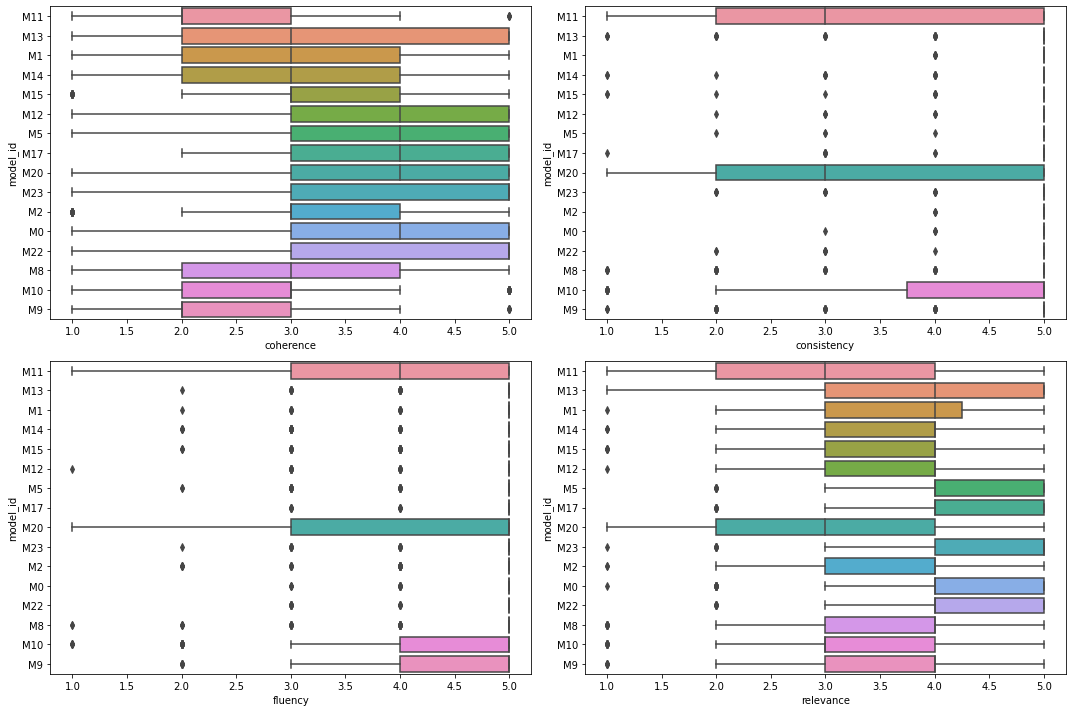

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), tight_layout=True)

ax = axes[0, 0]
sns.boxplot(data=summeval_orig, y="model_id", x=summeval_human_cols[0], ax=ax)

ax = axes[0, 1]
sns.boxplot(data=summeval_orig, y="model_id", x=summeval_human_cols[1], ax=ax)

ax = axes[1, 0]
sns.boxplot(data=summeval_orig, y="model_id", x=summeval_human_cols[2], ax=ax)

ax = axes[1, 1]
sns.boxplot(data=summeval_orig, y="model_id", x=summeval_human_cols[3], ax=ax)

<AxesSubplot:xlabel='relevance', ylabel='model_id'>

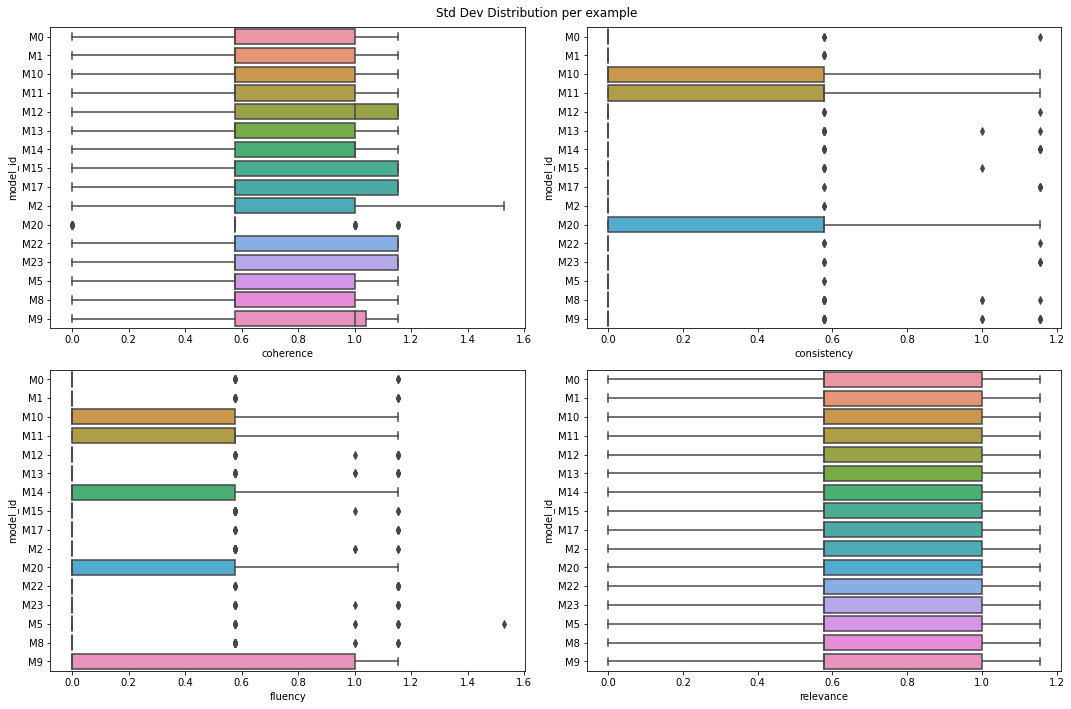

In [10]:
summeval_orig_std = summeval_orig.groupby(["id", "model_id"]).std().reset_index()

fig, axes = plt.subplots(2, 2, figsize=(15, 10), tight_layout=True)
fig.suptitle("Std Dev Distribution per example")

ax = axes[0, 0]
sns.boxplot(data=summeval_orig_std, y="model_id", x=summeval_human_cols[0], ax=ax)

ax = axes[0, 1]
sns.boxplot(data=summeval_orig_std, y="model_id", x=summeval_human_cols[1], ax=ax)

ax = axes[1, 0]
sns.boxplot(data=summeval_orig_std, y="model_id", x=summeval_human_cols[2], ax=ax)

ax = axes[1, 1]
sns.boxplot(data=summeval_orig_std, y="model_id", x=summeval_human_cols[3], ax=ax)

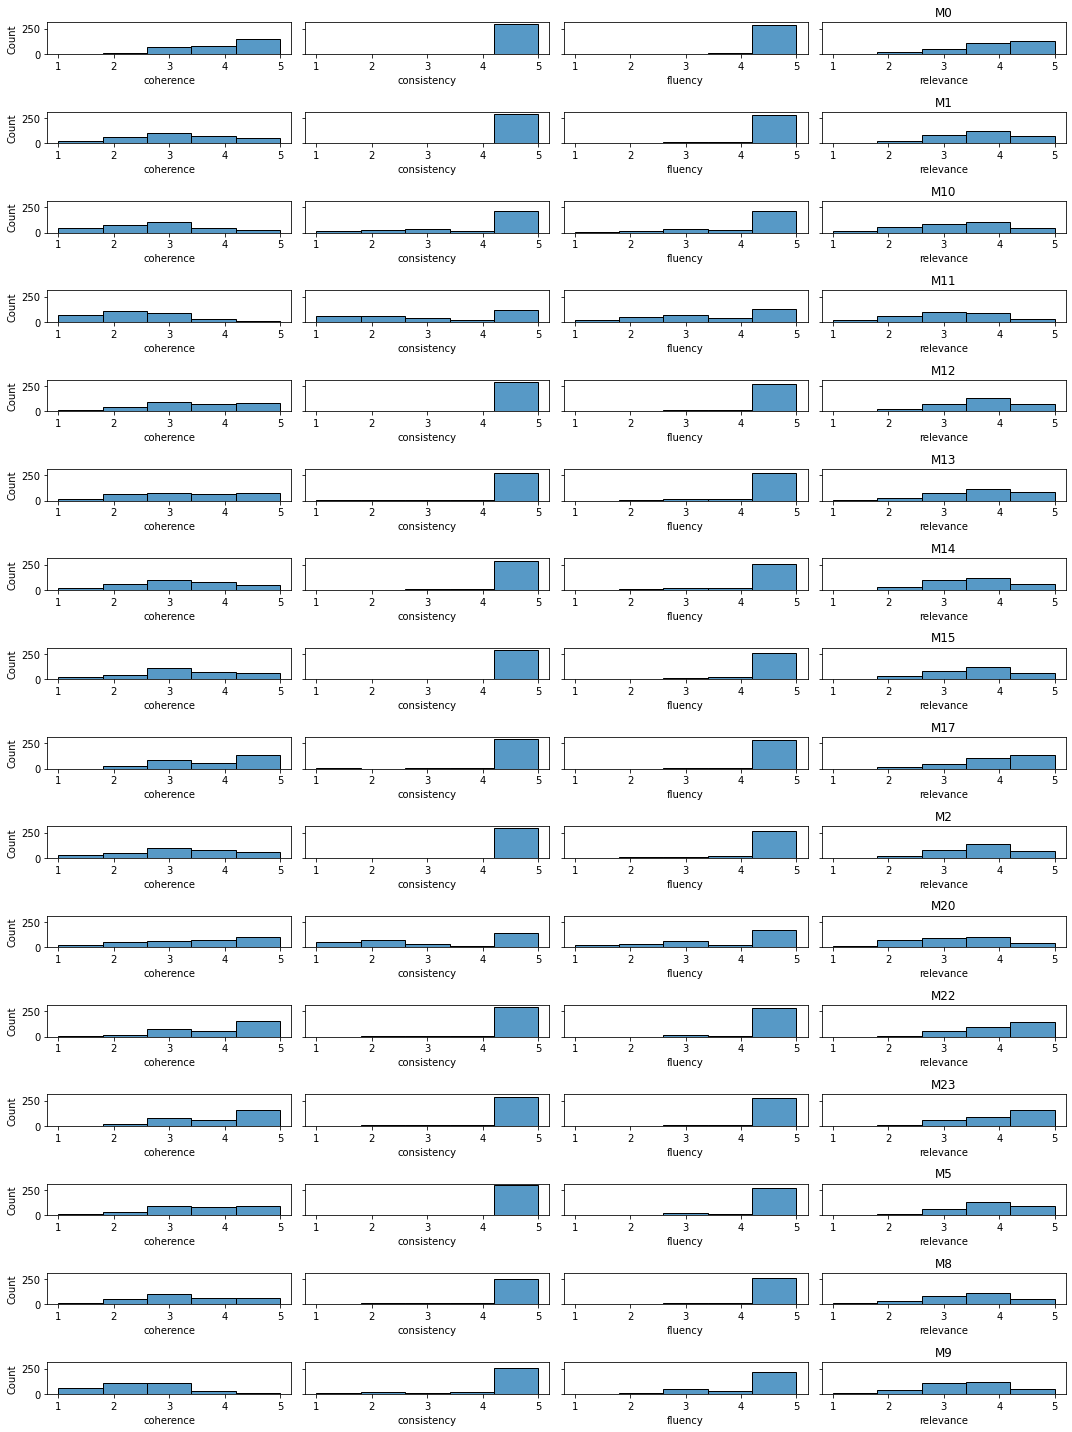

In [11]:
fig, axes = plt.subplots(nrows=summeval_orig_std.model_id.nunique(), ncols=4, sharey=True, tight_layout=True, figsize=(15, 20))
for i, model_id in enumerate(sorted(summeval_orig.model_id.unique())):
    data = summeval_orig[summeval_orig['model_id'] == model_id]

    ax = axes[i, 0]
    col = summeval_human_cols[0]
    sns.histplot(data[col], label=model_id, ax=ax, binrange=(1, 5), bins=5)
        
    ax = axes[i, 1]
    col = summeval_human_cols[1]
    sns.histplot(data[col], label=model_id, ax=ax, binrange=(1, 5), bins=5)
    
    ax = axes[i, 2]
    col = summeval_human_cols[2]
    sns.histplot(data[col], label=model_id, ax=ax, binrange=(1, 5), bins=5)
    
    ax = axes[i, 3]
    col = summeval_human_cols[3]
    sns.histplot(data[col], label=model_id, ax=ax, binrange=(1, 5), bins=5)
    ax.set_title(model_id)

**Conclusion**:
- Model evaluation does not take into account the uncertainty in the annotations.
- Consistency and fluency are highly left-skewed -- *does it mean these models are already good at these evaluation aspects*?

### Newsroom Annotation Uncertainty

In [12]:
newsroom.model.unique()

array(['pointer_s', 'pointer_n', 'pointer_c', 'abstractive', 'textrank',
       'fragments', 'lede3'], dtype=object)

**Note**: 
For Newsroom (2018) the BARTScore authors average the results of the annotators. However, this leads to loss of information, namely in terms of how much uncertainty we had on the annotators side. We can retrieve the original scores from [GitHub](https://github.com/lil-lab/newsroom/tree/master/humaneval)

In [13]:
ORIGINAL_NEWSROOM_EVAL_CSV = "https://raw.githubusercontent.com/lil-lab/newsroom/master/humaneval/newsroom-human-eval.csv" 
newsroom_orig = pd.read_csv(ORIGINAL_NEWSROOM_EVAL_CSV)
newsroom_orig = newsroom_orig.rename(mapper={f"{col.capitalize()}Rating": col for col in newsroom_human_cols}, axis=1)
newsroom_orig.tail()

,ArticleID,System,ArticleText,SystemSummary,ArticleTitle,coherence,fluency,informativeness,relevance
1255,1295,pointer_s,12/28/2015 AT 04:50 PM EST</p><p>Like a lot of...,"ultimately , stelling could n&#x27;t exclude s...","Beth Stelling Opens Up About Abuse, Rape on In...",4,3,4,4
1256,1295,pointer_s,12/28/2015 AT 04:50 PM EST</p><p>Like a lot of...,"ultimately , stelling could n&#x27;t exclude s...","Beth Stelling Opens Up About Abuse, Rape on In...",1,1,3,3
1257,2140,lede3,A worker sets up a polling station the morning...,A worker sets up a polling station the morning...,Why has GOP turnout taken a dive?,5,5,4,4
1258,2140,lede3,A worker sets up a polling station the morning...,A worker sets up a polling station the morning...,Why has GOP turnout taken a dive?,3,3,3,2
1259,2140,lede3,A worker sets up a polling station the morning...,A worker sets up a polling station the morning...,Why has GOP turnout taken a dive?,4,4,3,5


<AxesSubplot:xlabel='relevance', ylabel='System'>

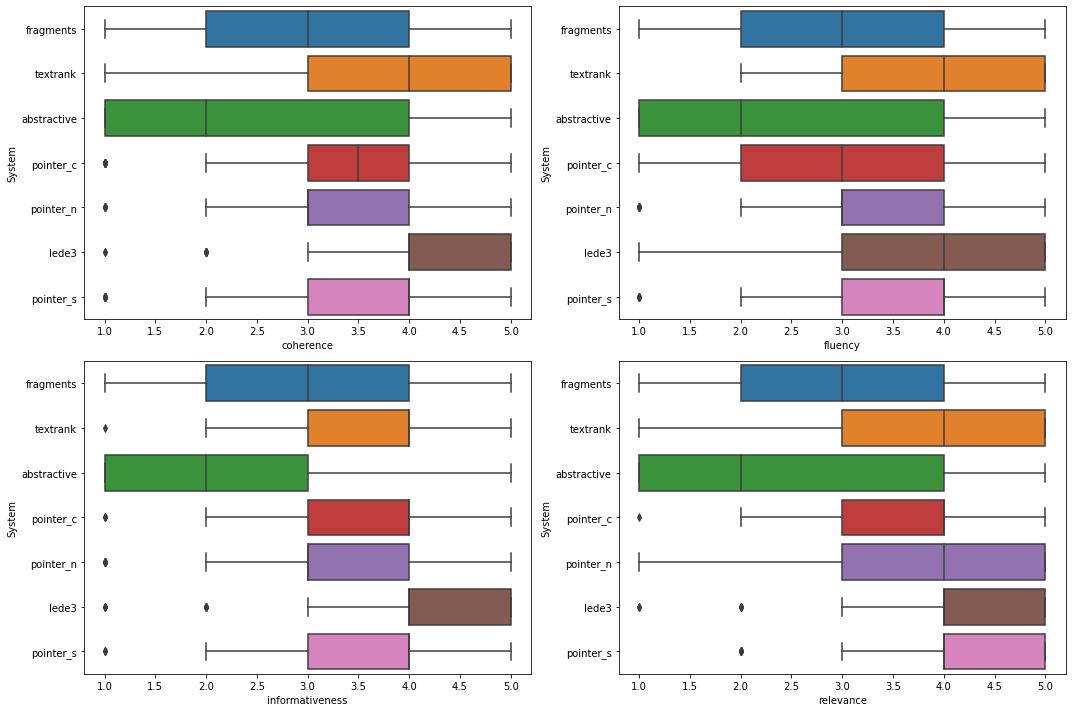

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), tight_layout=True)

ax = axes[0, 0]
sns.boxplot(data=newsroom_orig, y="System", x=newsroom_human_cols[0], ax=ax)

ax = axes[0, 1]
sns.boxplot(data=newsroom_orig, y="System", x=newsroom_human_cols[1], ax=ax)

ax = axes[1, 0]
sns.boxplot(data=newsroom_orig, y="System", x=newsroom_human_cols[2], ax=ax)

ax = axes[1, 1]
sns.boxplot(data=newsroom_orig, y="System", x=newsroom_human_cols[3], ax=ax)

<AxesSubplot:xlabel='relevance', ylabel='System'>

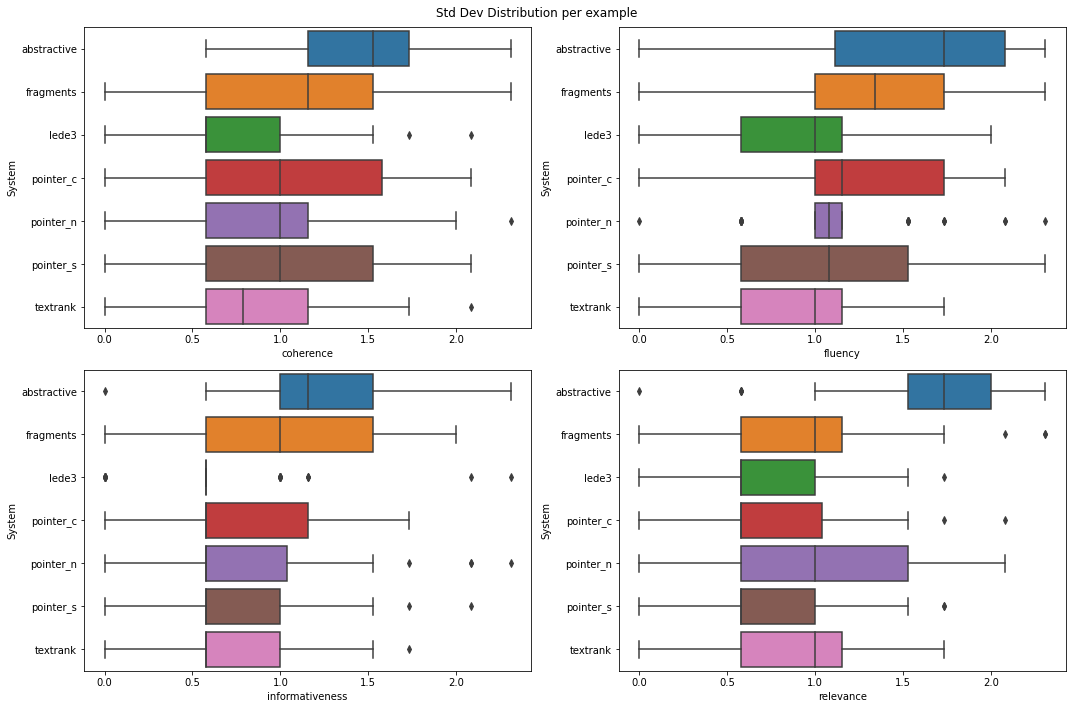

In [15]:
newsroom_orig_std = newsroom_orig.groupby(["ArticleID", "System"]).std().reset_index()

fig, axes = plt.subplots(2, 2, figsize=(15, 10), tight_layout=True)
fig.suptitle("Std Dev Distribution per example")

ax = axes[0, 0]
sns.boxplot(data=newsroom_orig_std, y="System", x=newsroom_human_cols[0], ax=ax)

ax = axes[0, 1]
sns.boxplot(data=newsroom_orig_std, y="System", x=newsroom_human_cols[1], ax=ax)

ax = axes[1, 0]
sns.boxplot(data=newsroom_orig_std, y="System", x=newsroom_human_cols[2], ax=ax)

ax = axes[1, 1]
sns.boxplot(data=newsroom_orig_std, y="System", x=newsroom_human_cols[3], ax=ax)

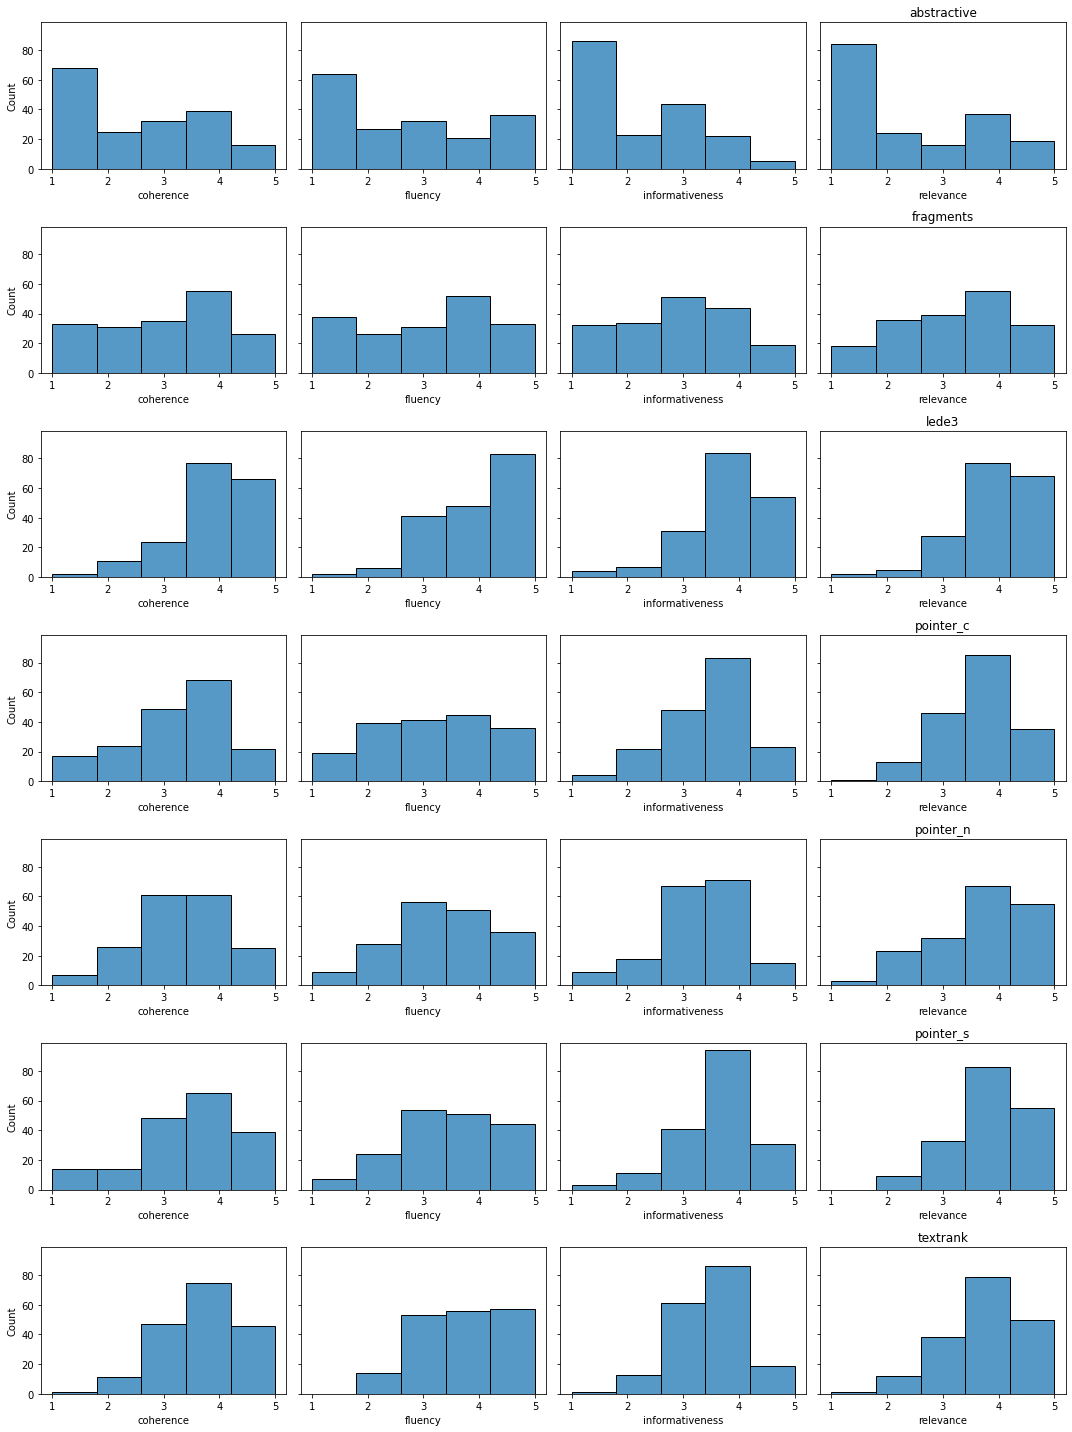

In [16]:
fig, axes = plt.subplots(nrows=newsroom_orig_std['System'].nunique(), ncols=4, sharey=True, tight_layout=True, figsize=(15, 20))
for i, model_id in enumerate(sorted(newsroom_orig_std['System'].unique())):
    data = newsroom_orig[newsroom_orig['System'] == model_id]

    ax = axes[i, 0]
    col = newsroom_human_cols[0]
    sns.histplot(data[col], label=model_id, ax=ax, binrange=(1, 5), bins=5)
        
    ax = axes[i, 1]
    col = newsroom_human_cols[1]
    sns.histplot(data[col], label=model_id, ax=ax, binrange=(1, 5), bins=5)
    
    ax = axes[i, 2]
    col = newsroom_human_cols[2]
    sns.histplot(data[col], label=model_id, ax=ax, binrange=(1, 5), bins=5)
    
    ax = axes[i, 3]
    col = newsroom_human_cols[3]
    sns.histplot(data[col], label=model_id, ax=ax, binrange=(1, 5), bins=5)
    ax.set_title(model_id)

**Conclusions**:

- fluency doesn't seem to be as extreme here. There seems to be more variability (though, in the SummEval paper, they do show _there is a substantial difference between expert annotations and crowdsourced_).

## Qualitative Analysis

/home/kat/miniconda3/envs/bartscore-env/lib/python3.8/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


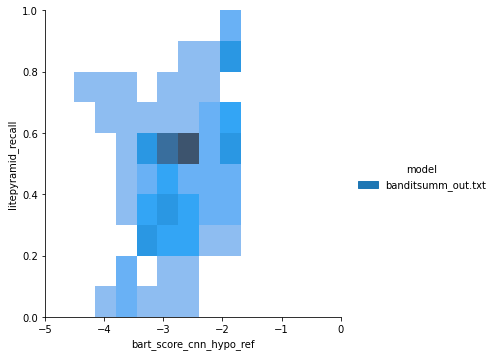

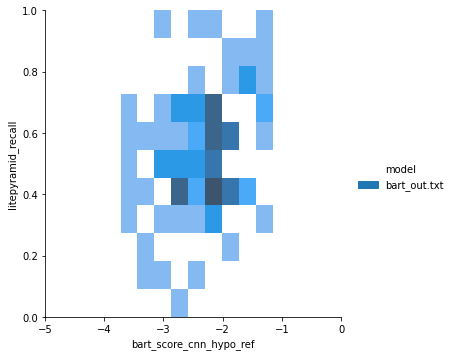

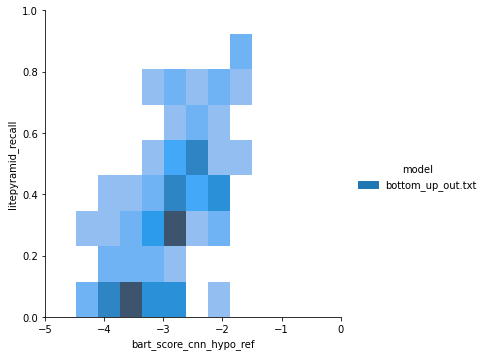

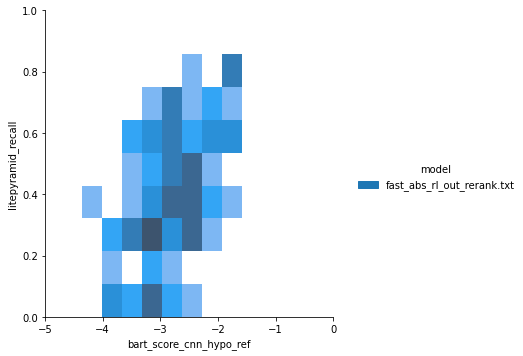

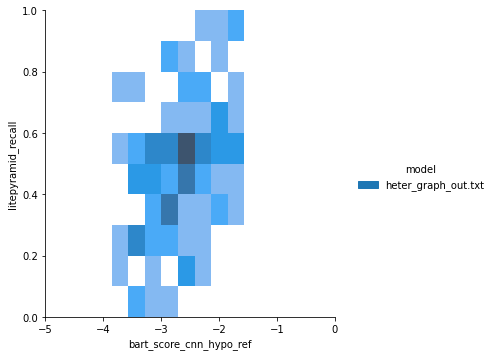

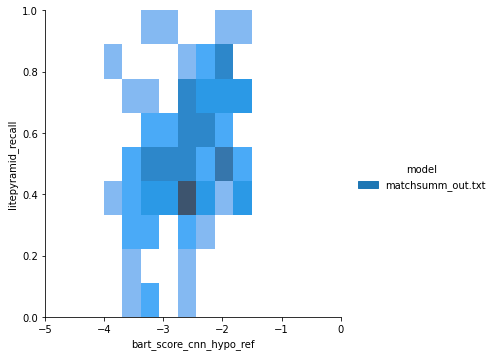

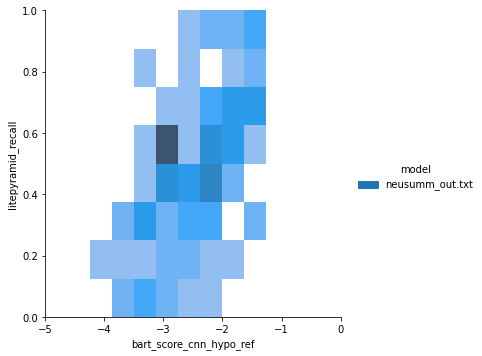

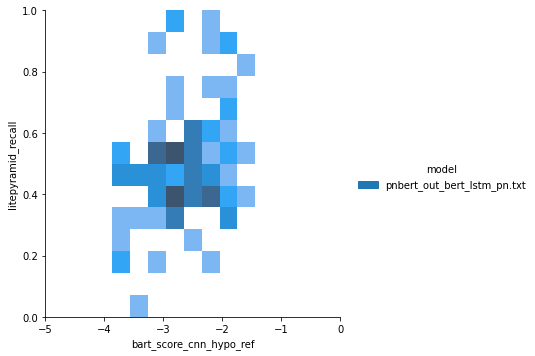

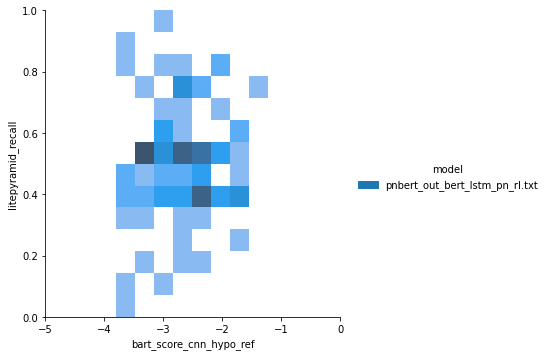

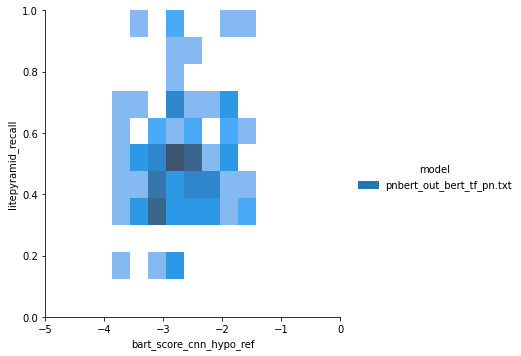

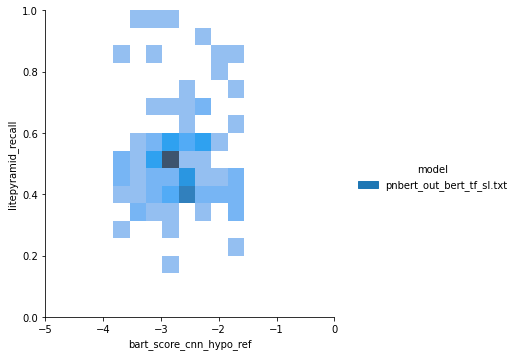

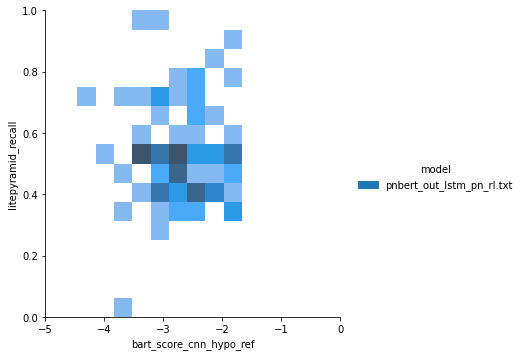

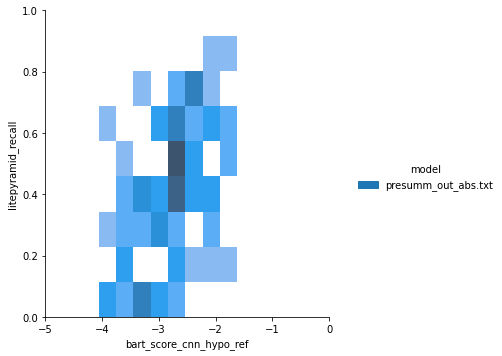

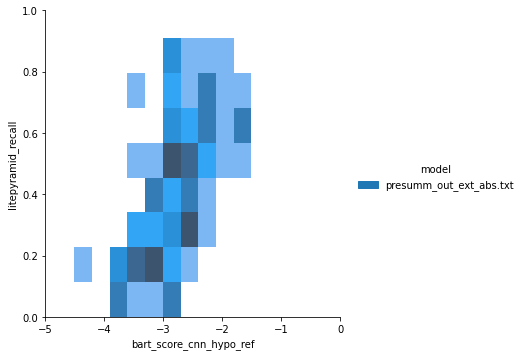

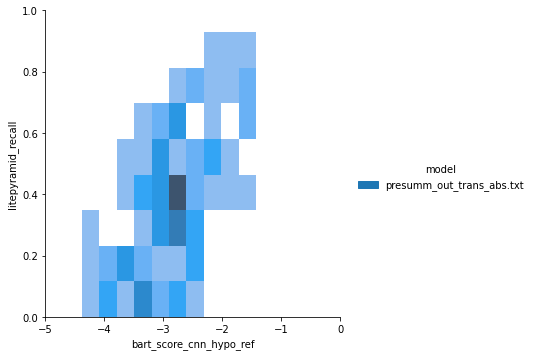

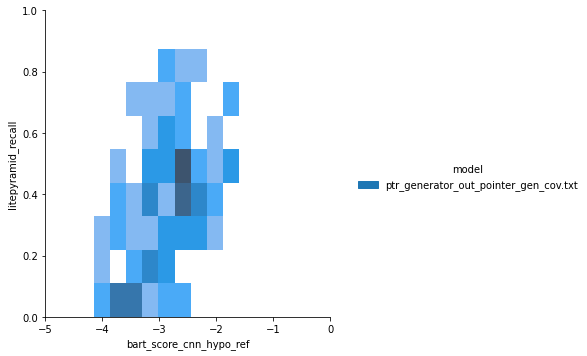

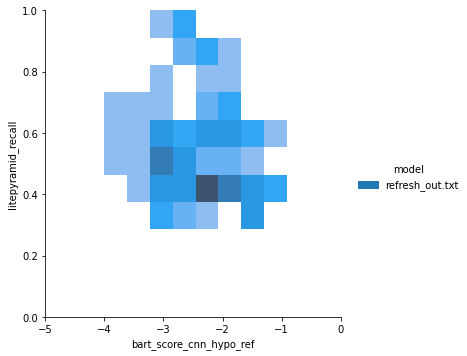

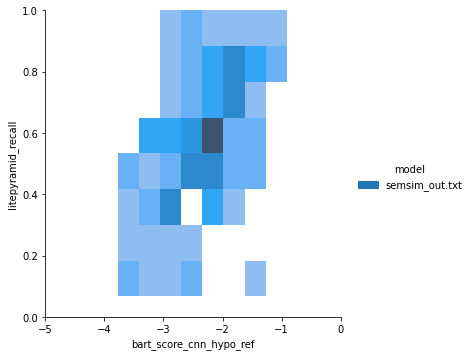

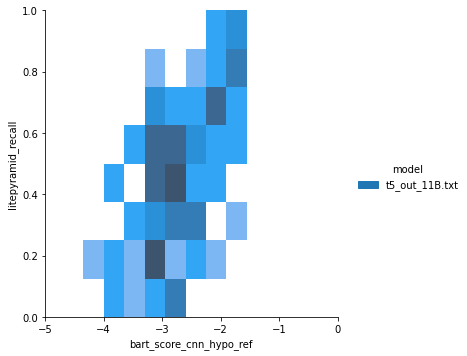

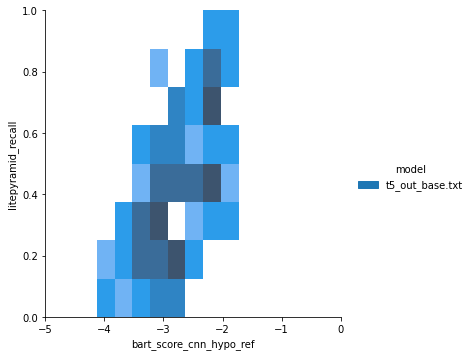

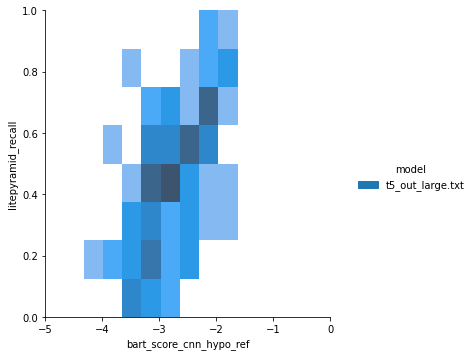

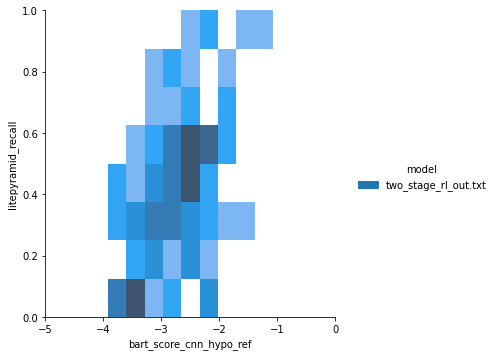

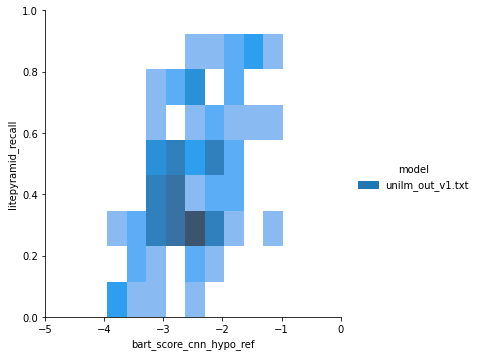

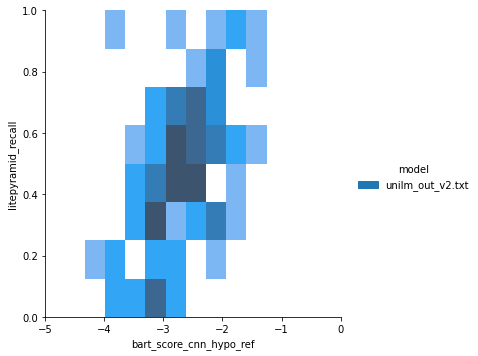

In [17]:
for model in sorted(realsumm.model.unique()):
    realsumm_model = realsumm[realsumm.model == model]
    sns.displot(data=realsumm_model, x=realsumm_bs_col, y=realsumm_human_cols[0], hue="model")
    plt.xlim(-5, 0)
    plt.ylim(0, 1)

### [RealSumm - COVERAGE] Qualitative analysis

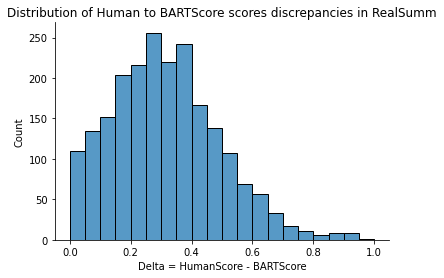

In [18]:
from sklearn.preprocessing import MinMaxScaler

realsumm[f"exp_{realsumm_bs_col}"] = realsumm[realsumm_bs_col].apply(np.exp)
mmscaler = MinMaxScaler()
realsumm[f"exp_{realsumm_bs_col}"] = mmscaler.fit_transform(realsumm[[f"exp_{realsumm_bs_col}"]])
realsumm[f"delta"] = realsumm[realsumm_human_cols[0]] - realsumm[f"exp_{realsumm_bs_col}"]

sns.histplot(realsumm["delta"], binrange=(0, 1), bins=20)
plt.title("Distribution of Human to BARTScore scores discrepancies in RealSumm")
plt.xlabel("Delta = HumanScore - BARTScore")
sns.despine()
plt.show()

In [19]:
REALSUMM_COV_ANALYSIS_THRESHOLD = 0.5
# Let us keep columns of interest
realsumm_cols = ["id", "model", "src", "reference", "candidate", realsumm_human_cols[0], f"exp_{realsumm_bs_col}"]
realsumm_analysis_mask = np.abs(realsumm["delta"]) > REALSUMM_COV_ANALYSIS_THRESHOLD

realsumm_analysis = realsumm[realsumm_analysis_mask][realsumm_cols + ["delta"]]
realsumm_analysis.to_csv(f"./qualitative_analysis/realsumm_delta_{REALSUMM_COV_ANALYSIS_THRESHOLD}.csv")
realsumm_analysis

,id,model,src,reference,candidate,litepyramid_recall,exp_bart_score_cnn_hypo_ref,delta
35,1,semsim_out.txt,They may look like as if they come from a plag...,Students from the University of Surrey discove...,The money was collected from students at the U...,1.000000,0.179617,0.820383
46,1,t5_out_large.txt,They may look like as if they come from a plag...,Students from the University of Surrey discove...,Thousands of bacteria colonies were discovered...,0.727273,0.089035,0.638238
66,2,heter_graph_out.txt,With the confirmation of danilo 's summer swit...,Danilo this week agreed to join Real Madrid in...,Porto and brazil right back danilo will join r...,0.900000,0.251224,0.648776
74,3,heter_graph_out.txt,"A dominatrix who claims she shared a ' hot , d...","Dominatrix claims she shared a ' hot , deep ki...","Carrie reichert ( left ) , 43 , has released a...",0.692308,0.170043,0.522265
75,3,matchsumm_out.txt,"A dominatrix who claims she shared a ' hot , d...","Dominatrix claims she shared a ' hot , deep ki...","A dominatrix who claims she shared a ` hot , d...",0.692308,0.184043,0.508265
...,...,...,...,...,...,...,...,...
2363,98,unilm_out_v1.txt,Eerie footage has emerged showing a mysterious...,Clip shows mysterious black cloud hanging over...,"The clip was filmed on Saturday in Shortandy ,...",0.777778,0.178811,0.598967
2364,98,presumm_out_trans_abs.txt,Eerie footage has emerged showing a mysterious...,Clip shows mysterious black cloud hanging over...,The video was filmed on saturday in shortandy ...,0.666667,0.141766,0.524900
2375,98,ptr_generator_out_pointer_gen_cov.txt,Eerie footage has emerged showing a mysterious...,Clip shows mysterious black cloud hanging over...,The clip was filmed on saturday in shortandy v...,0.777778,0.134472,0.643305
2388,99,presumm_out_abs.txt,Authorities in el salvador have moved prisoner...,Incredible images show handcuffed members from...,Images show handcuffed members from the notori...,0.777778,0.265615,0.512163


In [20]:
!ls

analysis.ipynb	      LICENSE			  requirements.txt
analysis.py	      models			  run.py
bartscore-env.tar.gz  __pycache__		  SUM
bart_score.py	      qualitative_analysis	  train
D2T		      qualitative-analysis.ipynb  utils.py
fig		      README.md			  WMT


In [21]:
from SUM.bart_score import BARTScorer
from utils import detokenize
bart_scorer_summ = BARTScorer(device="cuda:0", checkpoint='facebook/bart-large-cnn')

2022-08-24 05:17:48.629914: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-08-24 05:17:48.629928: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [22]:
def get_scores_realsumm(candidates, reference):
    reference = detokenize(reference)
    candidates = [detokenize(c) for c in candidates]

    curr_hypo_ref = bart_scorer_summ.score(candidates, [reference] * len(candidates), batch_size=len(candidates))
    curr_hypo_ref = mmscaler.transform(np.exp(curr_hypo_ref).reshape(-1, 1))
    for cand, score in zip(candidates, curr_hypo_ref):
        print(round(score[0], 2), cand)
        print()

In [23]:
reference = """Leanne Mitchell has been dropped by her label and sings at a holiday camp . Andrea Begley and Jermain Jackman are yet to become household names . Will 2015 winner Stevie become a chart success or another Voice flop ? ."""
candidates = [
    # System output
    """Stevie mccrorie has been crowned the winner of the voice uk 2015 , after beating fellow contestant lucy o'byrne in the final . Now mentor ricky wilson , his fellow celebrity judges rita ora , tom jones and will.i.am , and most of all bosses at the bbc will all have their fingers crossed for his success . His mentor ricky wilson is confident stevie could be just what the bbc needs to pull their talent show out of ridicule ."""
    # First sentence only 
    , """Stevie mccrorie has been crowned the winner of the voice uk 2015 , after beating fellow contestant lucy o'byrne in the final ."""
    # First sentence plus some other general artifact
    , """Stevie mccrorie has been crowned the winner of the voice uk 2015 , after beating fellow contestant lucy o'byrne in the final . This is true ."""
    # First sentence plus some other news-article artifact "click here or read more"
    , """Stevie mccrorie has been crowned the winner of the voice uk 2015 , after beating fellow contestant lucy o'byrne in the final . CLICK HERE for all the latest news and reaction following the chart success Stevie ."""
     # Last two sentences: (no change) -- even though no overlap w/ reference it achieves higher score.
    , """Now mentor ricky wilson , his fellow celebrity judges rita ora , tom jones and will.i.am , and most of all bosses at the bbc will all have their fingers crossed for his success . His mentor ricky wilson is confident stevie could be just what the bbc needs to pull their talent show out of ridicule ."""
    # Switch entities to be overlapping with the reference (Andrea Begley and Jermain Jackman); replace lucy o'byrn with Leanne Mitchell
    , """Stevie mccrorie has been crowned the winner of the voice uk 2015 , after beating fellow contestant Leanne Mitchell in the final . Now mentor ricky wilson , his fellow celebrity judges Andrea Begley , Jermain Jackman and will.i.am , and most of all bosses at the bbc will all have their fingers crossed for his success . His mentor ricky wilson is confident stevie could be just what the bbc needs to pull their talent show out of ridicule ."""
    # Switch entities to be overlapping with the reference (Andrea Begley and Jermain Jackman); replace lucy o'byrn with Leanne Mitchell
    , """Stevie mccrorie has been crowned the winner of the voice uk 2015 , after beating fellow contestant Leanne Mitchell in the final . Now mentor Leanne Mitchell , his fellow celebrity judges Andrea Begley , Jermain Jackman and Stevie , and most of all bosses at the bbc will all have their fingers crossed for his success . His mentor ricky wilson is confident stevie could be just what the bbc needs to pull their talent show out of ridicule ."""
    # All entities are Leanne Mitchel except in an enumeration (Andrea Begley and Jermain Jackman);
    , """Leanne Mitchel has been crowned the winner of the voice uk 2015 , after beating fellow contestant Leanne Mitchell in the final . Now mentor Leanne Mitchell , his fellow celebrity judges Andrea Begley , Jermain Jackman and Stevie , and most of all bosses at the bbc will all have their fingers crossed for his success . Her mentor Leanne Mitchell is confident stevie could be just what the bbc needs to pull their talent show out of ridicule ."""
    # Capitalize: voice -> Voice, uk -> UK and bbc -> BBC
    , """Stevie mccrorie has been crowned the winner of the Voice UK 2015 , after beating fellow contestant Leanne Mitchell in the final . Now mentor ricky wilson , his fellow celebrity judges Andrea Begley , Jermain Jackman and Will.I.Am , and most of all bosses at the BBC will all have their fingers crossed for his success . His mentor Ricky Wilson is confident Stevie could be just what the BBC needs to pull their talent show out of ridicule ."""
    # Remove all entities except overlapping ones (e.g., Stevie, the voice)
    , """Stevie mccrorie has been crowned the winner of the voice uk 2015 , after beating fellow contestant in the final . Now mentor, his fellow celebrity judges and most of all bosses at the bbc will all have their fingers crossed for his success . His mentor is confident Stevie could be just what the bbc needs to pull their talent show out of ridicule ."""
    # Repeat first sentence in the end too:
    , """Stevie mccrorie has been crowned the winner of the voice uk 2015 , after beating fellow contestant lucy o'byrne in the final . Now mentor ricky wilson , his fellow celebrity judges rita ora , tom jones and will.i.am , and most of all bosses at the bbc will all have their fingers crossed for his success . His mentor ricky wilson is confident stevie could be just what the bbc needs to pull their talent show out of ridicule . Stevie mccrorie has been crowned the winner of the voice uk 2015 , after beating fellow contestant lucy o'byrne in the final ."""
    # Simpler sentences
    , """Stevie mccrorie has been crowned the winner of the voice uk 2015 . Now mentor ricky wilson , his fellow celebrity judges rita ora , tom jones and will.i.am will all have their fingers crossed for his success . His mentor ricky wilson is confident stevie could be pull their talent show out of ridicule ."""
    # Negative
    , """Stevie mccrorie has not been crowned the winner of the voice uk 2015 , after beating fellow contestant lucy o'byrne in the final . Now mentor ricky wilson , his fellow celebrity judges rita ora , tom jones and will.i.am , and most of all bosses at the bbc will all have their fingers crossed for his success . His mentor ricky wilson is confident stevie could be just what the bbc needs to pull their talent show out of ridicule ."""
    
    # Repeat words
    """2015 winner Stevie mccrorie beat fellow contestant lucy o'byrne in the final . Now mentor ricky wilson , his fellow celebrity judges rita ora , tom jones and will.i.am , and most of all bosses at the bbc will all have their fingers crossed for his success . His mentor ricky wilson is confident stevie could be just what the bbc needs to pull their talent show out of ridicule ."""

]

get_scores_realsumm(candidates, reference)

0.0 Stevie mccrorie has been crowned the winner of the voice uk 2015, after beating fellow contestant lucy o'byrne in the final. Now mentor ricky wilson, his fellow celebrity judges rita ora, tom jones and will.i.am, and most of all bosses at the bbc will all have their fingers crossed for his success. His mentor ricky wilson is confident stevie could be just what the bbc needs to pull their talent show out of ridicule.

-0.0 Stevie mccrorie has been crowned the winner of the voice uk 2015, after beating fellow contestant lucy o'byrne in the final.

-0.0 Stevie mccrorie has been crowned the winner of the voice uk 2015, after beating fellow contestant lucy o'byrne in the final. This is true.

0.0 Stevie mccrorie has been crowned the winner of the voice uk 2015, after beating fellow contestant lucy o'byrne in the final. CLICK HERE for all the latest news and reaction following the chart success Stevie.

-0.01 Now mentor ricky wilson, his fellow celebrity judges rita ora, tom jones and wi

In [24]:
reference = "Woman reported ' someone ' had been run over , but victim was a squirrel . Another man dialled 999 to say he dropped a burger which was ' bleeding ' East of England ambulance service warned hoax calls can cost lives ."
candidates = [
    # original
    "When emergency crews received a call saying ` someone ' had been knocked down by a car in essex , they immediately sent two ambulances to the rescue . But the vehicles returned to base just moments later when the caller revealed the ` victim ' was actually a squirrel that had been run over in epping forest . Two ambulances were sent to epping forest after a caller told crews ` someone ' had been run down , only for the ` victim ' to turn out to be a squirrel ."
    # first sentence only
    , "When emergency crews received a call saying ` someone ' had been knocked down by a car in essex , they immediately sent two ambulances to the rescue ."
    # all except first
    , "But the vehicles returned to base just moments later when the caller revealed the ` victim ' was actually a squirrel that had been run over in epping forest . Two ambulances were sent to epping forest after a caller told crews ` someone ' had been run down , only for the ` victim ' to turn out to be a squirrel ."
    # 
    , "a call saying ` someone ' had been run over but the ` victim ' was a squirrel that had been run over ."""
    # 
    , "Woman reported ' someone ' had been run over , but victim was a squirrel ."
    , "Woman reported ' someone ' had been run over , but victim was a squirrel . CLICK HERE for all the latest news and reaction following the Squirrel ."
    # 
    , "Another man dialled 919 to say he dropped a burger which was ' bleeding ' East of England ambulance service warned hoax calls can cost lives ."
    # 
    , "Another man dialled 999 to say he dropped a burger which was ' bleeding ' East of England ambulance service warned hoax calls can cost lives ."
    , "Another man dialled 999 to say he dropped a burger ."
    , "Another man dialled 999 to say he dropped a ' bleeding ' burger and it was a hoax call ."
    
    # 
    , "Sources claim that women and men have been pulling up hoax calls which can cost lives. The earliest example is this woman who reports `someone ' has been run over in essex and does not provide additional information . It turns out that, when two ambulances arrived the `victim ' was actually a squirrel. This could prevent other people from getting the desired speed in healthcare needs. Another example is a man who calls 911 and reports his burger is ' bleeding ' at East of England "
    # Difference 911 -> 999
    , "Sources claim that women and men have been pulling up hoax calls which can cost lives. The earliest example is this woman who reports `someone ' has been run over in essex and does not provide additional information . It turns out that, when two ambulances arrived the `victim ' was actually a squirrel. This could prevent other people from getting the desired speed in healthcare needs. Another example is a man who calls 911 and reports of' bleeding 'burger"
    , "Sources claim that women and men have been pulling up hoax calls which can cost lives. The earliest example is this woman who reports `someone ' has been run over in essex and does not provide additional information . It turns out that, when two ambulances arrived the `victim ' was actually a squirrel. This could prevent other people from getting the desired speed in healthcare needs. Another example is a man who calls 999 and reports of' bleeding 'burger ."
    , "Stevie mccrorie has been crowned the winner of the voice uk 2015 , after beating fellow contestant lucy o'byrne in the final . Now mentor ricky wilson , his fellow celebrity judges rita ora , tom jones and will.i.am , and most of all bosses at the bbc will all have their fingers crossed for his success . Can this year 's the voice uk champion stevie mccrorie break the winners ' curse ? His mentor ricky wilson is confident stevie could be just what the bbc needs to pull their talent show out of ridicule . When emergency crews received a call saying ` someone ' had been knocked down by a car in essex , they immediately sent two ambulances to the rescue . But the vehicles returned to base just moments later when the caller revealed the ` victim ' was actually a squirrel that had been run over in epping forest . Two ambulances were sent to epping forest after a caller told crews ` someone ' had been run down , only for the ` victim ' to turn out to be a squirrel ."
    , "Stevie mccrorie has been crowned the winner of the voice uk 2015 , after beating fellow contestant lucy o'byrne in the final . Now mentor ricky wilson , his fellow celebrity judges rita ora , tom jones and will.i.am , and most of all bosses at the bbc will all have their fingers crossed for his success . Can this year 's the voice uk champion stevie mccrorie break the winners ' curse ? His mentor ricky wilson is confident stevie could be just what the bbc needs to pull their talent show out of ridicule . Another man dialled 999 to say he dropped a burger which was ' bleeding ' East of England ambulance service warned hoax calls can cost lives ."

]

get_scores_realsumm(candidates, reference)

0.02 When emergency crews received a call saying `someone 'had been knocked down by a car in essex, they immediately sent two ambulances to the rescue. But the vehicles returned to base just moments later when the caller revealed the` victim' was actually a squirrel that had been run over in epping forest. Two ambulances were sent to epping forest after a caller told crews `someone 'had been run down, only for the` victim' to turn out to be a squirrel.

-0.01 When emergency crews received a call saying `someone 'had been knocked down by a car in essex, they immediately sent two ambulances to the rescue.

0.02 But the vehicles returned to base just moments later when the caller revealed the `victim 'was actually a squirrel that had been run over in epping forest. Two ambulances were sent to epping forest after a caller told crews` someone' had been run down, only for the `victim 'to turn out to be a squirrel.

0.02 a call saying `someone 'had been run over but the` victim' was a squirre

In [25]:
reference = "Another man dialled 999 to say he dropped a burger which was ' bleeding ' East of England ambulance service warned hoax calls can cost lives . Woman reported ' someone ' had been run over , but victim was a squirrel ."
candidates = [
    # original
    "When emergency crews received a call saying ` someone ' had been knocked down by a car in essex , they immediately sent two ambulances to the rescue . But the vehicles returned to base just moments later when the caller revealed the ` victim ' was actually a squirrel that had been run over in epping forest . Two ambulances were sent to epping forest after a caller told crews ` someone ' had been run down , only for the ` victim ' to turn out to be a squirrel ."
    # first sentence only
    , "When emergency crews received a call saying ` someone ' had been knocked down by a car in essex , they immediately sent two ambulances to the rescue ."
    # all except first
    , "But the vehicles returned to base just moments later when the caller revealed the ` victim ' was actually a squirrel that had been run over in epping forest . Two ambulances were sent to epping forest after a caller told crews ` someone ' had been run down , only for the ` victim ' to turn out to be a squirrel ."
    # 
    , "a call saying ` someone ' had been run over but the ` victim ' was a squirrel that had been run over ."""
    # 
    "Another man dialled 999 to say he dropped a burger which was ' bleeding ' East of England ambulance service warned hoax calls can cost lives ."
    # use the document
    "When emergency crews received a call saying ' someone ' had been knocked down by a car in essex , they immediately sent two ambulances to the rescue . But the vehicles returned to base just moments later when the caller revealed the ' victim ' was actually a squirrel that had been run over in epping forest . The report forms just part of a long list released by east of england ambulance service detailing their most bizarre , and irritating , call outs . Two ambulances were sent to epping forest after a caller told crews ' someone ' had been run down , only for the ' victim ' to turn out to be a squirrel . Another man said he had dropped his burger and it was ' bleeding ' . Another came from reveller in basildon , essex , who said ' i 've dropped my burger and it is bleeding ' , while a third woman in chelmsford , dialled 999 to report ' i 've eaten too much takeaway food . ' The service said it receives around 2,500 calls per day , and in the last two years has had to deal with 1,248 that did not need emergency help . Front-line crews have attended almost half of the phoney calls , believing them to be genuine emergencies . Also on the list is a woman from shoeburyness who called to say she was locked out of the house , while a man in peterborough called to say his feet hurt after wearing shoes that were too small . In hitchin , hertfordshire , a man told 999 staff : ' i have been dieting and feel lethargic . ' Gary morgan , regional head of emergency operations centres , asked people to use common-sense when calling , adding that misguided or hoax calls could cost lives . East on england ambulance revealed the bizarre calls as part of a list of 1,248 inappropriate call outs , saying that crew attended half of them , potentially putting lives at risk ( file image ) . He said : ' we 're an emergency service and our front-line staff are trained to save lives . ' However , sadly , some of the calls we receive are not even medically related and we will refer hoax calls to the police . ' We prioritise all life-threatening calls to get the quickest possible response . ' However , that response can be affected if our call handlers and front-line staff are dealing with inappropriate 999 calls . ' We would strongly urge people who think it is funny to make a prank call to stop and think about the potential consequences . ' In another strange call one woman phoned to say she felt ill after eating too much takeaway , while a man reported that his feet were hurting after wearing shoes that were too tight ."
]

get_scores_realsumm(candidates, reference)

0.01 When emergency crews received a call saying `someone 'had been knocked down by a car in essex, they immediately sent two ambulances to the rescue. But the vehicles returned to base just moments later when the caller revealed the` victim' was actually a squirrel that had been run over in epping forest. Two ambulances were sent to epping forest after a caller told crews `someone 'had been run down, only for the` victim' to turn out to be a squirrel.

-0.01 When emergency crews received a call saying `someone 'had been knocked down by a car in essex, they immediately sent two ambulances to the rescue.

0.01 But the vehicles returned to base just moments later when the caller revealed the `victim 'was actually a squirrel that had been run over in epping forest. Two ambulances were sent to epping forest after a caller told crews` someone' had been run down, only for the `victim 'to turn out to be a squirrel.

0.6 a call saying `someone 'had been run over but the` victim' was a squirrel

Observations:
- Lyte Pyramid Recall is too subjective, and unclear how many of the SCUs were actually shown for each summary/reference pair.
- Unclear why human annotations are so high. 
- Summaries are copies of the source text. 
- Irrealistic to ask $\mathbb{P}(ref|hyp)$ to reflect quality of summaries, given that BART finetuned w/ CNN was finetuned to produce summaries from longer documents. In general, having longer sentences improves probability slightly, even if it has nothing to do with the story.

In [26]:
realsumm.describe()[[f"exp_{realsumm_bs_col}"] + realsumm_human_cols]

,exp_bart_score_cnn_hypo_ref,litepyramid_recall
count,2400.000000,2400.000000
mean,0.182864,0.458491
std,0.132366,0.222605
min,0.000000,0.000000
25%,0.087954,0.333333
50%,0.146687,0.454545
75%,0.246147,0.600000
max,1.000000,1.000000


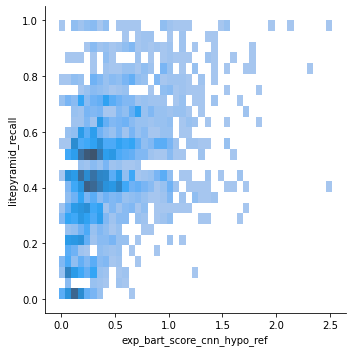

In [27]:
sns.displot(x=(realsumm[f"exp_{realsumm_bs_col}"] - 0.010) / (0.403 - 0.010), y=realsumm[realsumm_human_cols[0]])

<AxesSubplot:xlabel='exp_bart_score_cnn_hypo_ref', ylabel='Count'>

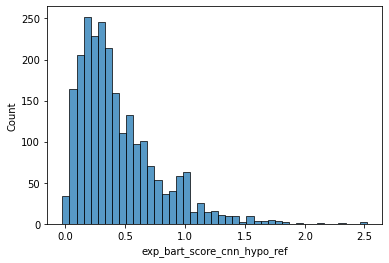

In [28]:
sns.histplot((realsumm[f"exp_{realsumm_bs_col}"] - 0.010) / (0.403 - 0.010))

In [29]:
reference = "Abby Bishop took in her two - day - old niece Zala in August 2013 . Now Zala is 20 months old and she follows Bishop as she travels the world playing for professional basketball teams . Bishop said it was a big decision but she would n't change anything . Zala will go with her when she starts playing in the U.S. WNBA in May ."
candidates = [
    "But when basketballer Abby Bishop was just 24 , her life completely changed when she took in her two-day-old niece Zala . It was August 2013 and Bishop suddenly found herself caring for a newborn , juggling training with sleepless nights and adjusting to her new life . Now Zala is 20 months old and she follows Bishop as she travels the world playing for professional teams , and will go with her to the U.S. this May when she starts playing for the Seattle Storm in the WNBA . Bishop , now 26 , said it was a big decision at the time but she would n't change anything .",
    
]

get_scores_realsumm(candidates, reference)

1.0 But when basketballer Abby Bishop was just 24, her life completely changed when she took in her two-day-old niece Zala. It was August 2013 and Bishop suddenly found herself caring for a newborn, juggling training with sleepless nights and adjusting to her new life. Now Zala is 20 months old and she follows Bishop as she travels the world playing for professional teams, and will go with her to the U.S. this May when she starts playing for the Seattle Storm in the WNBA. Bishop, now 26, said it was a big decision at the time but she would n't change anything.



## SummEval $\mathbb{P}(hyp|src)$

In [30]:
from SUM.bart_score import BARTScorer
from utils import detokenize
bart_scorer_summ = BARTScorer(device="cuda:0", checkpoint='facebook/bart-large-cnn')

In [147]:
summeval_bs_col

'bart_score_cnn_src_hypo'

coherence


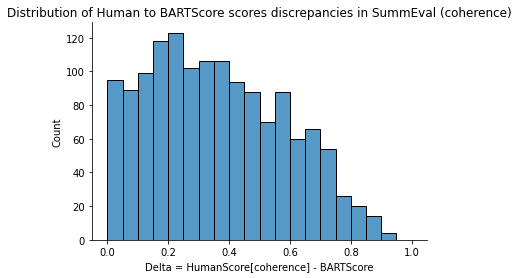

consistency


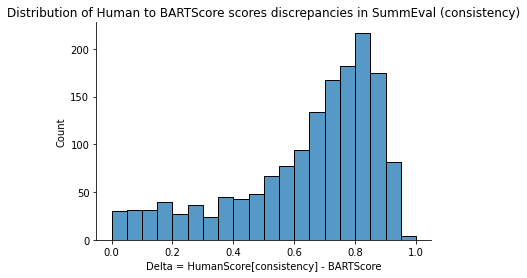

fluency


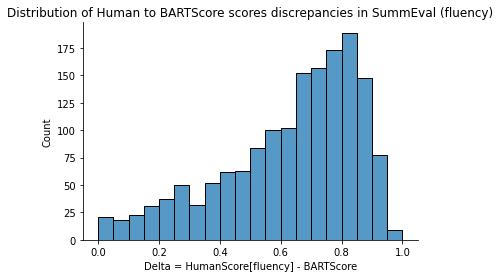

relevance


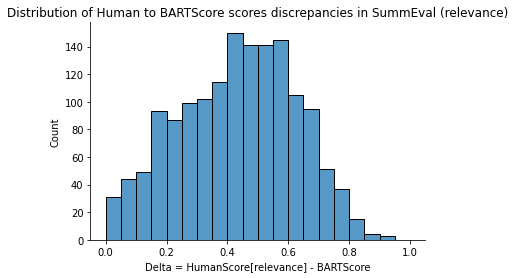

In [31]:
from sklearn.preprocessing import MinMaxScaler

summeval[f"exp_{summeval_bs_col}"] = summeval[summeval_bs_col].apply(np.exp)
mm_bs_scaler = MinMaxScaler()
summeval[f"exp_{summeval_bs_col}"] = mm_bs_scaler.fit_transform(summeval[[f"exp_{summeval_bs_col}"]])

for summeval_human_col in summeval_human_cols:
    print(summeval_human_col)
    mm_human_scaler = MinMaxScaler()
    summeval[summeval_human_col] = mm_human_scaler.fit_transform(summeval[[summeval_human_col]]) 

    summeval[f"delta_{summeval_human_col}"] = summeval[summeval_human_col] - summeval[f"exp_{summeval_bs_col}"]

    sns.histplot(summeval[f"delta_{summeval_human_col}"], binrange=(0, 1), bins=20)
    plt.title(f"Distribution of Human to BARTScore scores discrepancies in SummEval ({summeval_human_col})")
    plt.xlabel(f"Delta = HumanScore[{summeval_human_col}] - BARTScore")
    sns.despine()
    plt.show()

<AxesSubplot:xlabel='exp_bart_score_cnn_src_hypo', ylabel='Count'>

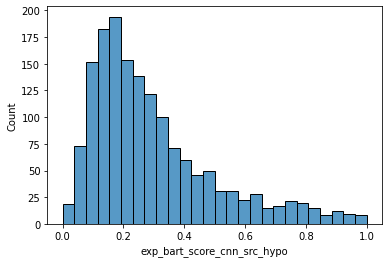

In [49]:
sns.histplot(summeval[f"exp_{summeval_bs_col}"])

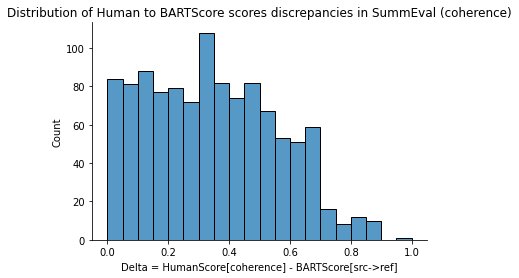

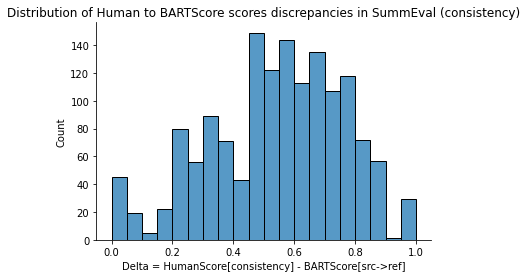

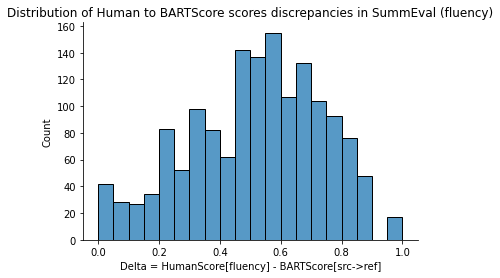

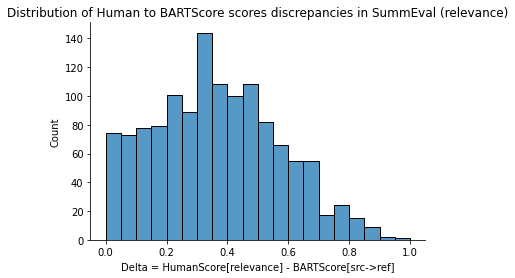

In [32]:
src_ref = bart_scorer_summ.score(summeval["src"].apply(detokenize).tolist(), summeval["reference"].apply(detokenize).tolist(),  batch_size=len(candidates))
src_ref = np.exp(src_ref)

mm_bs_scaler = MinMaxScaler()
summeval[f"exp_BARTScore_cnn_src_ref"] = mm_bs_scaler.fit_transform(src_ref.reshape(-1, 1))

for summeval_human_col in summeval_human_cols:
    summeval[f"delta_src_ref_{summeval_human_col}"] = summeval[summeval_human_col] - summeval["exp_BARTScore_cnn_src_ref"]

    sns.histplot(summeval[f"delta_src_ref_{summeval_human_col}"], binrange=(0, 1), bins=20)
    plt.title(f"Distribution of Human to BARTScore scores discrepancies in SummEval ({summeval_human_col})")
    plt.xlabel(f"Delta = HumanScore[{summeval_human_col}] - BARTScore[src->ref]")
    sns.despine()
    plt.show()

In [51]:
def get_scores_summeval(candidates, source):
    source = detokenize(source)
    candidates = [detokenize(c) for c in candidates]
    curr_src_hypo = bart_scorer_summ.score([source] * len(candidates), candidates, batch_size=len(candidates))
    curr_src_hypo = mm_bs_scaler.transform(np.exp(curr_src_hypo).reshape(-1, 1))
    for cand, score in zip(candidates, curr_src_hypo):
        print(round(score[0], 2), cand)
        print()

In [55]:
# BARTScore has a limit on the tokens it observes: it's not a problem for datasets 
# in which expected summary is within the first max_length /0.4 tokens (approximately)
bart_scorer_summ.max_length

1024

In [97]:
source = """A video of a menacing crocodile swimming through a public marina with a dead pet dog locked in between its jaws has been viewed more than half a million times online . The clip shows a large croc calmly moving through the marina in the tourist hotspot of Puerto Vallarta , in Mexico , with a black dog wearing a red collar lifeless in its mouth . New Zealander Tim Weston was on holiday in Puerto Vallarta with his wife when the attack happened and described how 'the crocodile kept the dog in its mouth for ages , not moving at all ' . Mr Weston told Daily Mail Australia the dog belonged to the local bike shop 's owner . Scroll down for video The large croc proudly held on to its catch for hours as it lurked around the Puerto Vallarta marina , in Mexico 'There 's a sanctuary for these crocodiles up the river ( 200m away ) which runs out to the sea and the marina , ' Mr Weston explained . 'The dog went to the water 's edge to see the crocodile ( being curious I guess ) but things did n't go according to plan obviously . 'It was certainly a shock to the system . Guess that 's nature though , ' he said . In the video the beast glides through the water , with rocks on one side and a footpath on the other , as crowds gasp in amazement . New Zealander Tim Weston was on holiday in Puerto Vallarta with his wife when he saw the alarming sight Tourist Tim Weston took a photo of the crocodile with the dog between its jaws A video of the crocodile swimming through the marina with the bike shop owner 's dog has been viewed more than 500,000 times Mr Weston said : ' A couple of hours later we walked back past and there was still a crowd ... But we did n't want to look at it again as we had just eaten . Yesterday morning there was no sign of either . ' Social media users have reacted in horror to the video that was posted on the Bogged Facebook page . One woman called the video 'horrible ' and another said ' I hate crocodiles now ' . But crocodiles are a common site in Puerto Vallarta as the Mexican beach resort is built amongst the mangroves that the creatures have called home for centuries . As well as living in the nearby sanctuary , crocs are regularly spotted on the resort 's golf course . In Mexico the 'American Crocodiles ' can reach lengths of 6 meters and as a result of urbanisation are living closer to humans than ever before . One social media user called the video 'horrible ' and another said ' I hate crocodiles now '"""
candidates = [
    # Original
    """New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .""",
    # Capitalization (massive increase in score 0.24 -> 0.62)
    """New Zealander Tim Weston was on holiday in Puerto Vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told Daily Mail Australia the dog belonged to the local bike shop 's owner .""",
    # Variations of capitalization
    """New zealander was on holiday in puerto vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told Daily Mail Australia the dog belonged to the local bike shop 's owner .""",
    """New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told Daily Mail Australia the dog belonged to the local bike shop 's owner .""",
    """New zealander tim weston was on holiday in Puerto Vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .""",
    """New Zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .""",
    # Change city w/ capital of mexico puerto vallarta --> Mexico City (decrease)
    """New zealander tim weston was on holiday in Mexico City with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .""",
    # Negation of events (decrease score): however, negating shouldn't have impact on all other evaluation aspects (but merely on factuality)
    """New zealander tim weston was not on holiday in puerto vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .""",
    # Change of events (decrease score): 
    """New zealander tim weston was swimming in puerto vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .""",
    # Synonyms (decrease score): 0.24 -> 0.2 (if plural then 0.19)
    """New zealander tim weston was on vacation in puerto vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .""",
    ## Does synonym affect the same when entities are capitalized (0.62 -> 0.49)
    """New Zealander Tim Weston was on vacation in Puerto Vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told Daily Mail Australia the dog belonged to the local bike shop 's owner .""",
    ## Order inversion tim weston was on holiday with his wife -? time weston and his wife were (decrease BARTScore)
    """New zealander tim weston and his wife were on holiday in puerto vallarta when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .""",
    """New zealander tim weston and his wife were in puerto vallarta when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .""",

    
    # Sentences from the document get higher score
    """The clip shows a large croc calmly moving through the marina""",
]


get_scores_summeval(candidates, source)

0.24 New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how `the crocodile kept the dog in its mouth for ages, not moving at all 'he told daily mail australia the dog belonged to the local bike shop's owner.

0.62 New Zealander Tim Weston was on holiday in Puerto Vallarta with his wife when the attack happened and described how `the crocodile kept the dog in its mouth for ages, not moving at all 'he told Daily Mail Australia the dog belonged to the local bike shop's owner.

0.34 New zealander was on holiday in puerto vallarta with his wife when the attack happened and described how `the crocodile kept the dog in its mouth for ages, not moving at all 'he told Daily Mail Australia the dog belonged to the local bike shop's owner.

0.3 New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how `the crocodile kept the dog in its mouth for ages, not moving at all 'he told Dai

In [141]:

print(source[:int(1024/0.4)])

A video of a menacing crocodile swimming through a public marina with a dead pet dog locked in between its jaws has been viewed more than half a million times online . The clip shows a large croc calmly moving through the marina in the tourist hotspot of Puerto Vallarta , in Mexico , with a black dog wearing a red collar lifeless in its mouth . New Zealander Tim Weston was on holiday in Puerto Vallarta with his wife when the attack happened and described how 'the crocodile kept the dog in its mouth for ages , not moving at all ' . Mr Weston told Daily Mail Australia the dog belonged to the local bike shop 's owner . Scroll down for video The large croc proudly held on to its catch for hours as it lurked around the Puerto Vallarta marina , in Mexico 'There 's a sanctuary for these crocodiles up the river ( 200m away ) which runs out to the sea and the marina , ' Mr Weston explained . 'The dog went to the water 's edge to see the crocodile ( being curious I guess ) but things did n't go 

In [150]:
source_diff_order = "The large croc proudly held on to its catch for hours as it lurked around the Puerto Vallarta marina , in Mexico 'There 's a sanctuary for these crocodiles up the river ( 200m away ) which runs out to the sea and the marina , ' Mr Weston explained . 'The dog went to the water 's edge to see the crocodile ( being curious I guess ) but things did n't go according to plan obviously . 'It was certainly a shock to the system . Guess that 's nature though , ' he said . In the video the beast glides through the water , with rocks on one side and a footpath on the other , as crowds gasp in amazement . New Zealander Tim Weston was on holiday in Puerto Vallarta with his wife when he saw the alarming sight Tourist Tim Weston took a photo of the crocodile with the dog between its jaws A video of the crocodile swimming through the marina with the bike shop owner 's dog has been viewed more than 500,000 times Mr Weston said : ' A couple of hours later we walked back past and there was still a crowd ... But we did n't want to look at it again as we had just eaten . Yesterday morning there was no sign of either . Scroll down for video A video of a menacing crocodile swimming through a public marina with a dead pet dog locked in between its jaws has been viewed more than half a million times online . The clip shows a large croc calmly moving through the marina in the tourist hotspot of Puerto Vallarta , in Mexico , with a black dog wearing a red collar lifeless in its mouth . New Zealander Tim Weston was on holiday in Puerto Vallarta with his wife when the attack happened and described how 'the crocodile kept the dog in its mouth for ages , not moving at all ' . Mr Weston told Daily Mail Australia the dog belonged to the local bike shop 's owner . ' Social media users have reacted in horror to the video that was posted on the Bogged Facebook page . One woman called the video 'horrible ' and another said ' I hate crocodiles now ' . But crocodiles are a common site in Puerto Vallarta as the Mexican beach resort is built amongst the mangroves that the creatures have called home for centuries . As well as living in the nearby sanctuary , crocs are regularly spotted on the resort 's golf course . In Mexico the 'American Crocodiles ' can reach lengths of 6 meters and as a result of urbanisation are living closer to humans than ever before . One social media user called the video 'horrible ' and another said ' I hate crocodiles now '"


candidates_fluency = [
    # Original
    "New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .",
    # -----------------------------------------------
    # Introduce grammar errors 
    # -----------------------------------------------
    # -- (was -> were) (0.24 -> 0.12)
    """New zealander tim weston were on holiday in puerto vallarta with his wife when the attack happened and described how ` the crocodile kept the god in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .""",
    # -- happened happens (0.24 -> 0.13)
    """New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happens and describes how ` the crocodile kept the dog in its teeth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .""",
    # -- (his -> her) (0.24 -> 0.14)
    """New zealander tim weston was on holiday in puerto vallarta with her wife when the attack happened and described how ` the crocodile kept the god in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .""",
   # -- drop "and" (0.24 -> 0.2)
    "New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .",
    # -- plural (0.24 -> 0.09)
    """New zealander tim weston were on holiday in puerto vallarta with his wifes when the attack happened and described how ` the crocodile kept the god in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .""",
    # -----------------------------------------------
    # Capitalization 0.24 -> 0.62
    # -----------------------------------------------
    """New Zealander Tim Weston was on holiday in Puerto Vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told Daily Mail Australia the dog belonged to the local bike shop 's owner .""",
    # Changing capitalization changes score considerably even if it's the wrong fact
    
    # Wrong syntax not penalized (country name instead of nationality)
    "New Zealand tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .",
]

get_scores_summeval(candidates_fluency, source[:int(1024/0.4)])
print("\n-------------------------\n\n")
get_scores_summeval(candidates_fluency, source_diff_order)

0.24 New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how `the crocodile kept the dog in its mouth for ages, not moving at all 'he told daily mail australia the dog belonged to the local bike shop's owner.

0.12 New zealander tim weston were on holiday in puerto vallarta with his wife when the attack happened and described how `the crocodile kept the god in its mouth for ages, not moving at all 'he told daily mail australia the dog belonged to the local bike shop's owner.

0.16 New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happens and describes how `the crocodile kept the dog in its teeth for ages, not moving at all 'he told daily mail australia the dog belonged to the local bike shop's owner.

0.14 New zealander tim weston was on holiday in puerto vallarta with her wife when the attack happened and described how `the crocodile kept the god in its mouth for ages, not moving at all 

In [146]:
candidates_coherence = [
    # Original
    "New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .",
    # Should penalize if invert order of sentences (barely penalized)
    "New zealander tim weston described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner . He was on holiday in puerto vallarta with his wife when the attack happened .",
    # Proper punctuation / simpler sentences (as expected): increases (0.24 -> 0.31)
    "New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened. He described how `the crocodile kept the dog in its mouth for ages, not moving at all '. He told daily mail australia the dog belonged to the local bike shop's owner.",
    # Add nonsense descriptions in between sentences (e.g., state Tim Weston is a tourist) (0.24 -> 0.25)
    "New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened. He described how `the crocodile kept the dog in its mouth for ages, not moving at all '. Tim weston is a tourist. He told daily mail australia the dog belonged to the local bike shop's owner.",
    # Adding more sentences that are disconnected (e.g., the video description) boosts score even further.
    "New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened. A video of a menacing crocodile swimming through a public marina has been viewed more than half a million times online . He described how `the crocodile kept the dog in its mouth for ages, not moving at all '. He told daily mail australia the dog belonged to the local bike shop's owner.",   
    
    # Add "Mr Weston said"
    # adding wrong information is scored higher than default summary: (0)
    "New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened. Mr Weston said ' I hate crocodiles now ' . He described how `the crocodile kept the dog in its mouth for ages, not moving at all '. He told daily mail australia the dog belonged to the local bike shop's owner.",    
    
    # Adding artifacts like: CLICK HERE for the latest news increases BARTScore
    "New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened. He described how `the crocodile kept the dog in its mouth for ages, not moving at all '. He told daily mail australia the dog belonged to the local bike shop's owner. CLICK HERE for the latest news .",   

]
get_scores_summeval(candidates_coherence, source[:int(1024/0.4)])

print("\n-------------------------\n\n")
get_scores_summeval(candidates_coherence, source_diff_order)

0.24 New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how `the crocodile kept the dog in its mouth for ages, not moving at all 'he told daily mail australia the dog belonged to the local bike shop's owner.

0.23 New zealander tim weston described how `the crocodile kept the dog in its mouth for ages, not moving at all 'he told daily mail australia the dog belonged to the local bike shop's owner. He was on holiday in puerto vallarta with his wife when the attack happened.

0.31 New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened. He described how `the crocodile kept the dog in its mouth for ages, not moving at all '. He told daily mail australia the dog belonged to the local bike shop's owner.

0.25 New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened. He described how `the crocodile kept the dog in its mouth for ages, not moving at al

In [129]:
print(source[:int(1024/0.4)])

A video of a menacing crocodile swimming through a public marina with a dead pet dog locked in between its jaws has been viewed more than half a million times online . The clip shows a large croc calmly moving through the marina in the tourist hotspot of Puerto Vallarta , in Mexico , with a black dog wearing a red collar lifeless in its mouth . New Zealander Tim Weston was on holiday in Puerto Vallarta with his wife when the attack happened and described how 'the crocodile kept the dog in its mouth for ages , not moving at all ' . Mr Weston told Daily Mail Australia the dog belonged to the local bike shop 's owner . Scroll down for video The large croc proudly held on to its catch for hours as it lurked around the Puerto Vallarta marina , in Mexico 'There 's a sanctuary for these crocodiles up the river ( 200m away ) which runs out to the sea and the marina , ' Mr Weston explained . 'The dog went to the water 's edge to see the crocodile ( being curious I guess ) but things did n't go 

In [138]:
candidates_factuality = [
    # Original
    "New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .",
    # intrinsic hallucination: use another nationality from the text 
    "Mexican tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .",
    # intrinsic hallucination: use time frame
    "Yesterday morning Tim Weston was on holiday in puerto vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .",
    # 
    "New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened. Tourist Tim Weston was frightened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .",
    # Omit fact that dog is from bike's shop owner
    "New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .",
    
    # 
    "New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner . He walked back to his hotel as he had just eaten .",
]


get_scores_summeval(candidates_factuality, source[:int(1024/0.4)])

0.24 New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how `the crocodile kept the dog in its mouth for ages, not moving at all 'he told daily mail australia the dog belonged to the local bike shop's owner.

0.21 Mexican tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how `the crocodile kept the dog in its mouth for ages, not moving at all 'he told daily mail australia the dog belonged to the local bike shop's owner.

0.21 Yesterday morning Tim Weston was on holiday in puerto vallarta with his wife when the attack happened and described how `the crocodile kept the dog in its mouth for ages, not moving at all 'he told daily mail australia the dog belonged to the local bike shop's owner.

0.21 New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened. Tourist Tim Weston was frightened and described how `the crocodile kept the dog in its m

In [140]:
get_scores_summeval(candidates_factuality, source_diff_order)

0.24 New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how `the crocodile kept the dog in its mouth for ages, not moving at all 'he told daily mail australia the dog belonged to the local bike shop's owner.

0.21 Mexican tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how `the crocodile kept the dog in its mouth for ages, not moving at all 'he told daily mail australia the dog belonged to the local bike shop's owner.

0.21 Yesterday morning Tim Weston was on holiday in puerto vallarta with his wife when the attack happened and described how `the crocodile kept the dog in its mouth for ages, not moving at all 'he told daily mail australia the dog belonged to the local bike shop's owner.

0.21 New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened. Tourist Tim Weston was frightened and described how `the crocodile kept the dog in its m

In [57]:
candidates_relevance = [
    # Original
    "New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how ` the crocodile kept the dog in its mouth for ages , not moving at all ' he told daily mail australia the dog belonged to the local bike shop 's owner .",
    # 
]


get_scores_summeval(candidates_relevance, source[:int(1024/0.4)])

0.24 New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how `the crocodile kept the dog in its mouth for ages, not moving at all 'he told daily mail australia the dog belonged to the local bike shop's owner.



In [58]:
get_scores_summeval(candidates, source[int(1024/0.4):]) 

-0.07 New zealander tim weston was on holiday in puerto vallarta with his wife when the attack happened and described how `the crocodile kept the dog in its mouth for ages, not moving at all 'he told daily mail australia the dog belonged to the local bike shop's owner.



In [46]:
SUMMEVAL_ANALYSIS_THRESHOLD = 0.8
SUMM_EVAL_COLS = ["id", "model", "src", "candidate", "reference"] 
SUMM_EVAL_COLS += summeval_human_cols 
SUMM_EVAL_COLS += [f"exp_{summeval_bs_col}"]
SUMM_EVAL_COLS += [f"delta_{summeval_human_col}" for summeval_human_col in summeval_human_cols]

# Let us keep columns of interest
summeval_analysis_mask = (
      (np.abs(summeval["delta_consistency"]) > SUMMEVAL_ANALYSIS_THRESHOLD) 
    | (np.abs(summeval["delta_coherence"]) > SUMMEVAL_ANALYSIS_THRESHOLD)
    | (np.abs(summeval["delta_fluency"]) > SUMMEVAL_ANALYSIS_THRESHOLD)
    | (np.abs(summeval["delta_relevance"]) > SUMMEVAL_ANALYSIS_THRESHOLD)
)
summeval_analysis = summeval[summeval_analysis_mask][SUMM_EVAL_COLS]
summeval_analysis.to_csv(f"./qualitative_analysis/summeval_delta_{SUMMEVAL_ANALYSIS_THRESHOLD}.csv")
summeval_analysis

,id,model,src,candidate,reference,coherence,consistency,fluency,relevance,exp_bart_score_cnn_src_hypo,delta_coherence,delta_consistency,delta_fluency,delta_relevance
2,cnn-test-404f859482d47c127868964a9a39d1a7645dd2e9,M9,( CNN ) Donald Sterling 's racist remarks cost...,Donald sterling 's remarks cost him an nba tea...,V. Stiviano must pay back $ 2.6 million in gif...,0.416667,1.0,1.000000,0.833333,0.122272,0.294395,0.877728,0.877728,0.711061
4,cnn-test-404f859482d47c127868964a9a39d1a7645dd2e9,M8,( CNN ) Donald Sterling 's racist remarks cost...,Rochelle `` shelly `` sterling accused stivian...,V. Stiviano must pay back $ 2.6 million in gif...,0.583333,1.0,1.000000,0.333333,0.156784,0.426550,0.843216,0.843216,0.176550
7,cnn-test-404f859482d47c127868964a9a39d1a7645dd2e9,M2,( CNN ) Donald Sterling 's racist remarks cost...,A los angeles judge has ordered v. stiviano to...,V. Stiviano must pay back $ 2.6 million in gif...,0.833333,1.0,0.833333,0.833333,0.180964,0.652369,0.819036,0.652369,0.652369
8,cnn-test-404f859482d47c127868964a9a39d1a7645dd2e9,M23,( CNN ) Donald Sterling 's racist remarks cost...,A los angeles judge orders v. stiviano to pay ...,V. Stiviano must pay back $ 2.6 million in gif...,0.916667,1.0,1.000000,0.833333,0.180335,0.736331,0.819665,0.819665,0.652998
11,cnn-test-404f859482d47c127868964a9a39d1a7645dd2e9,M5,( CNN ) Donald Sterling 's racist remarks cost...,( cnn ) donald sterling 's racist remarks cost...,V. Stiviano must pay back $ 2.6 million in gif...,0.916667,1.0,1.000000,0.916667,0.160160,0.756507,0.839840,0.839840,0.756507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574,dm-test-f5fead94ee884800e84a212cc0edc78b11c4ba9f,M2,Manchester City are keen to sign Anderlecht te...,Manchester city are keen to sign anderlecht te...,Evangelos Patoulidis also attracted interest f...,0.416667,1.0,1.000000,0.750000,0.183769,0.232898,0.816231,0.816231,0.566231
1578,dm-test-f5fead94ee884800e84a212cc0edc78b11c4ba9f,M5,Manchester City are keen to sign Anderlecht te...,Manchester city are keen to sign anderlecht te...,Evangelos Patoulidis also attracted interest f...,0.833333,1.0,1.000000,0.833333,0.161496,0.671838,0.838504,0.838504,0.671838
1580,dm-test-f5fead94ee884800e84a212cc0edc78b11c4ba9f,M15,Manchester City are keen to sign Anderlecht te...,Manchester city are keen to sign anderlecht te...,Evangelos Patoulidis also attracted interest f...,0.666667,1.0,0.916667,0.750000,0.144176,0.522491,0.855824,0.772491,0.605824
1581,dm-test-f5fead94ee884800e84a212cc0edc78b11c4ba9f,M11,Manchester City are keen to sign Anderlecht te...,Evangelos patoulidis is regarded as one of the...,Evangelos Patoulidis also attracted interest f...,0.416667,1.0,0.833333,0.666667,0.095934,0.320733,0.904066,0.737399,0.570733


### WMT 

In [29]:
from analysis import WMTStat
# The path to the scored file, _p means we have prompted metrics
wmt_stat = WMTStat('WMT/de-en/data.pkl')
wmt_stat.data[0]

{'src': 'Das Register soll Organspenden erleichtern und Angehörige in Stresssituationen entlasten.',
 'ref': 'The register should facilitate organ donations and relieve relatives in stressful situations.',
 'better': {'sys_name': 'uedin.6749',
  'sys': 'The register is designed to facilitate organ donation and relieve relatives in stressful situations.',
  'scores': {}},
 'worse': {'sys_name': 'online-A.0',
  'sys': 'The register is intended to facilitate organ donation and relieve the burden on relatives in stressful situations.',
  'scores': {}}}

In [ ]:
# TODO List
# Get WMT'19 scores
# - [ ] If no scores, try to explain how to obtain the correlation
# - [ ] How do they measure adequacy and fluency?
# FInd errors for examples w/ max diff between predicted scores and human annotations
# - [ ]
# - [ ] Optional, Check likelihood of intermediate sentences
# Perturb reference annots w/ known biases:
# - [ ] Replace common words w/ rarer words
# - [ ] PLural/gender
# - [ ] sensitivity to click here, read more, URLs, ...
# - [ ] can also try out some of the errors mentioned in the frank benchmark
# [Optional] Rerun BARTScore for summeval
# - [ ] What preprocessing do they apply?
# [Optional] Rerun BARTScore for WMT'19
# - [ ] What preprocessing do they apply? is it the same for all metrics? why why not?

In [33]:
exp = "The gift of an inquiring mind can be both exhilarating and torturous"

In [42]:
rs = [rs_src[:100] for rs_src in sorted(realsumm.src.unique())]
se = [se_src[:100] for se_src in sorted(summeval.src.unique())]
se

['( CNN ) A North Pacific gray whale has earned a spot in the record books after completing the longes',
 '( CNN ) A fiery sunset greeted people in Washington Sunday . The deep reddish color caught Seattle n',
 '( CNN ) After a Russian fighter jet intercepted a U.S. reconnaissance plane in an `` unsafe and unpr',
 "( CNN ) Donald Sterling 's racist remarks cost him an NBA team last year . But now it 's his former ",
 '( CNN ) Eight Iranian border guards have been killed in clashes with militants near the border with ',
 '( CNN ) ISIS on Wednesday released more than 200 Yazidis , a minority group whose members were kille',
 "( CNN ) Lady Antebellum singer Hillary Scott 's tour bus caught fire on a Texas freeway Thursday mor",
 '( CNN ) One of the biggest TV events of all time is being reimagined for new audiences . `` Roots , ',
 '( CNN ) SpaceX on Tuesday launched a two-stage Falcon 9 rocket carrying an uncrewed cargo spacecraft',
 "( CNN ) The classic video game `` Space Invaders '' w